# Flag Reporting and Metrics

## David Lewis, Arizona State University, 2018

As part of the effort to determine suitable observations for the IDR3 release, this notebook was created to view flagging data from the flag files automatically generated using XRFI.

The workflow for this notebook is as follows: first, a script was run on the NRAO cluster reading in the flags.npz (and flag_summary.npz for time info) files, and averaging them across all baselines. They were further averaged over both time and channel, and the resulting arrays were saved into external npz files named 'JD_plot_arrays.npz', with JD being replaced by the appropriate Julian day. Those files are then read by this notebook, which opens them up and plots them using appropriate axes.

In [48]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.ticker as ticker
import os
import glob as glob
import itertools
import astropy.units as u
from astropy.time import Time
from astropy.coordinates import get_sun
from astropy.coordinates import SkyCoord, EarthLocation, AltAz
from pyuvdata import UVData
import json
import math

np.set_printoptions(threshold='nan')


In [49]:
DATA_PATH='/lustre/aoc/projects/hera/dlewis/flagreports_xant_test'
plot_files=glob.glob(DATA_PATH + '/*_plot_arrays.npz')
plot_files.sort()
# plot_files=plot_files[0:50]
print plot_files

['/lustre/aoc/projects/hera/dlewis/flagreports_xant_test/2458026_plot_arrays.npz', '/lustre/aoc/projects/hera/dlewis/flagreports_xant_test/2458027_plot_arrays.npz', '/lustre/aoc/projects/hera/dlewis/flagreports_xant_test/2458028_plot_arrays.npz', '/lustre/aoc/projects/hera/dlewis/flagreports_xant_test/2458029_plot_arrays.npz', '/lustre/aoc/projects/hera/dlewis/flagreports_xant_test/2458030_plot_arrays.npz', '/lustre/aoc/projects/hera/dlewis/flagreports_xant_test/2458032_plot_arrays.npz', '/lustre/aoc/projects/hera/dlewis/flagreports_xant_test/2458033_plot_arrays.npz', '/lustre/aoc/projects/hera/dlewis/flagreports_xant_test/2458034_plot_arrays.npz', '/lustre/aoc/projects/hera/dlewis/flagreports_xant_test/2458035_plot_arrays.npz', '/lustre/aoc/projects/hera/dlewis/flagreports_xant_test/2458036_plot_arrays.npz', '/lustre/aoc/projects/hera/dlewis/flagreports_xant_test/2458037_plot_arrays.npz', '/lustre/aoc/projects/hera/dlewis/flagreports_xant_test/2458038_plot_arrays.npz', '/lustre/aoc/pr

In [50]:
# print len(plot_files)
numplts=len(plot_files)
if np.mod(numplts, 4)!=0:
    numrows=int(numplts/4)+1
else:
    numrows=(numplts/4)
# print numrows

In [51]:
#convert channel average times to LST, used to stack plots together and offset based on LST
#open timearray
# Location coords 30° 43′ 17.26″ S, 21° 25′ 41.59″ E
# Location coords -30.72146, 21.42822
heraLat='-30.72146' 
heraLon='21.42822'
heraTime=[0]*numplts
heraTimeLST=[0]*numplts
heraTimeYDT=[0]*numplts
heraTimeLocal=[0]*numplts

#use astropy to convert

#plot using iterable vertical offset, horizontal offset based on LST
for i, plotfile in enumerate(plot_files):
#     print i
    openFile=np.load(plotfile)
    heraTime[i]=Time(openFile['flag_times_xx'],location=(heraLat, heraLon),format='jd', scale='utc')
    heraTimeLST[i]=heraTime[i].sidereal_time('apparent')
    heraTimeYDT[i]=heraTime[i].datetime
#     heraTimeLocal[i]=[0]*len(heraTimeYDT[i])
#     for j in range(len(heraTimeYDT[i])):
#         heraTimeLocal[i][j]=heraTimeYDT[i][j][-12:]
        



The notes in this section are taken from the HERA_observing_log spreadsheet, and they are automatically placed onto the appropriate plots.

In [106]:
#make the list of notes for these observations
notes=[None]*numplts
for i,flagfile in enumerate(plot_files):
    notes[i]=[os.path.split(flagfile)[1][:7],'None']
    noteSwitch= {
        '2458042':'Golden Day/IDR1',
        '2458053':'Roach 6 stopped roaching. Roaches restarted. then an xengine (px4) died and was restarted',
        '2458057':'X engine borked, first half of the night',
        '2458060':'power outage on site, correlator reset, xbox error no data!',
        '2458061':'discovered xbox error (timing mismatch), power cycled xbox and back on air',
        '2458067':'Data link down during the day; observing seems unaffected',
        '2458071':'Extra data taken to observe NGC4993',
        '2458072':'Extra data taken to observe NGC4993',
        '2458073':'3 extra data files taken ~10am SAST; yy polarization missing; data transfer \n was invoked while acquisition was happening, so some data may be corrupted',
        '2458074':'Data connection to container went down',
        '2458080':'First day back after outage; roaches not synced at beginning of day',
        '2458082':'Roaches not programmed first half of night',
        '2458091':'Session broken up in librarian due to interrupted upload',
        '2458093':'lightning',
        '2458094':'Session broken up in librarian due to interrupted upload',
        '2458097':'8 observations missing from middle of day',
        '2458098':'RTP V2, 5 new antennas',
        '2458100':'1 xbox broken late in the day; restarted',
        '2458102':'Link to site broken, fixed same day',
        '2458103':'no email from site',
        '2458104':'no email from site',
        '2458117':'bad xbox',
        '2458130':'bad xbox, internet down',
        '2458131':'internet down',
        '2458132':'jack on site',
        '2458133':'jack on site',
        '2458134':'restart observing with xbox fixed?',
        '2458137':'notebook is scary',
        '2458138':'still pretty scary, flags and chisq',
        '2458134':'meh, better but...',
        '2458152':'antenna 68 xpoled halfway through the night?',
        '2458156':'rxr\'s 3 and 5 off',
        '2458157':'back on ',
        '2458160':'this notebook is fishy, metrics are missing',
        '2458162':'something fishy going on in the correlator, troubles with the librarian mean data movement happening during the night ',
        '2458163':'h1c branch of hera_cal and pyuvdata updated; outriggers added to PULL_SUBARRAY step',
        '2458164':'why xants==0???',
        '2458166':'FIRE wow, lots of low autos and spectrally variable autos in start report',
        '2458167':'Report of wind on 166, discussion in #heracommissioning 19 Feb',
        '2458171':'Ant 65 was broadcasting! Fixed by Kathryn and Ziyaad',
        '2458172':'start report looks good',
        '2458178':'Digital bug',
        '2458179':'Digital bug, Fengine restart seems to have fixed it.  GPSdaemon tells us \n the antenna is shorted, no lock and GPS 10MHz clock is undisciplined. 1pps is offset from paper1 clock by 0.3s',
        '2458184':'GPS unplugged for 4 seconds, stopped observing, restarted Fengines',
        '2458194':'px4 is broken. Hickish reset on the 17th'
        }
    argNote=notes[i][0]
#     print argNote
    notes[i][1]=noteSwitch.get(notes[i][0],'None')

    jdArray=[0]*numplts
for i in range(numplts):
    jdArray[i]=int(notes[i][0])

In [143]:
dayAvg=np.zeros(numplts)
dayAvg2=np.zeros(numplts)
frameAltAz=[0]*numplts
sunAltAz=[0]*numplts
nxantArrxx=[0]*numplts
nxantArryy=[0]*numplts
seasonFlag_xx=[0]*numplts
seasonFlag_yy=[0]*numplts

hera=EarthLocation(lat=heraLat, lon=heraLon)
dayAvgSun=[0]*numplts
for i, flagfile in enumerate(plot_files):
    frameAltAz[i]=AltAz(obstime=heraTime[i], location=hera)
    sunAltAz[i]=get_sun(heraTime[i]).transform_to(frameAltAz[i])
    plot_arrays=np.load(flagfile)
#     dayAvgSun[i]=[plot_arrays['chan_mean_xx'][j] for j,times in enumerate(plot_arrays['flag_times_xx']) if sunAltAz[i][j].alt < -18*u.deg]
    if int(os.path.split(flagfile)[1][:7])>2458040:
        dayAvg[i]=np.average(plot_arrays['chan_mean_xx'])
        dayAvg2[i]=np.average(plot_arrays['time_mean_xx'])
        nxantArrxx[i]=len(plot_arrays['xants_xx'])
        nxantArryy[i]=len(plot_arrays['xants_yy'])
        seasonFlag_xx[i]=plot_arrays['chan_mean_xx']
        seasonFlag_yy[i]=plot_arrays['chan_mean_yy']
    else:
        dayAvg[i]=np.average(plot_arrays['chan_mean_xx_old'])
        dayAvg2[i]=np.average(plot_arrays['time_mean_xx_old'])
        nxantArrxx[i]=len(plot_arrays['xants_xx'])
        nxantArryy[i]=len(plot_arrays['xants_yy'])
        seasonFlag_xx[i]=plot_arrays['chan_mean_xx_old']
        seasonFlag_yy[i]=plot_arrays['chan_mean_yy_old']


avgDiff=dayAvg-dayAvg2

In [85]:
nxantArrxx=nxantArrXX

In [54]:
for i in range(len(dayAvgSun)):
    dayAvgSun[i]=np.average(dayAvgSun[i])

In [ ]:
print plot_files

The following plots form the meat of this report. On the left is a time-averaged plot, and on the right is a channel-averaged plot. Notes are placed using the array created in the cell above. Also note that the channel-averaged plot gives a visual representation of the sun's altitude; in particular, it shows where the sun is below the horizon(grey) and when astronomical twilight ends and night begins (black).

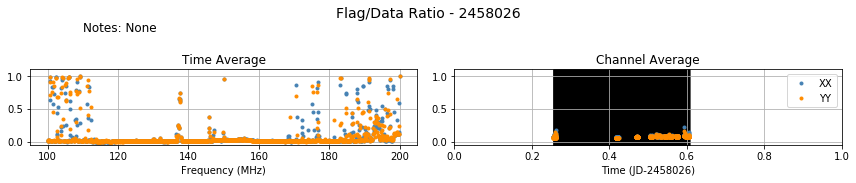

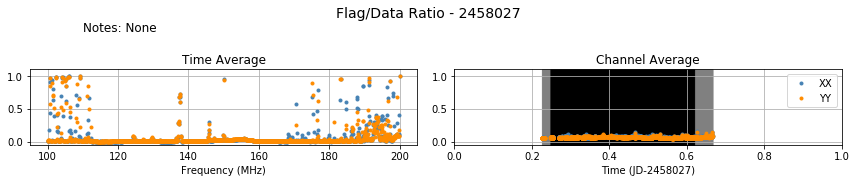

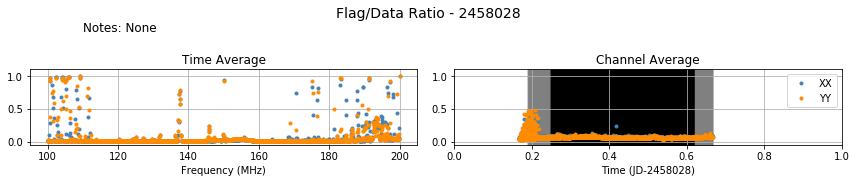

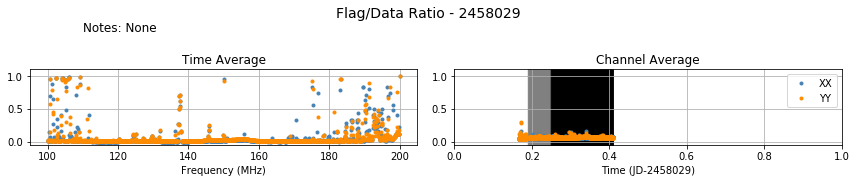

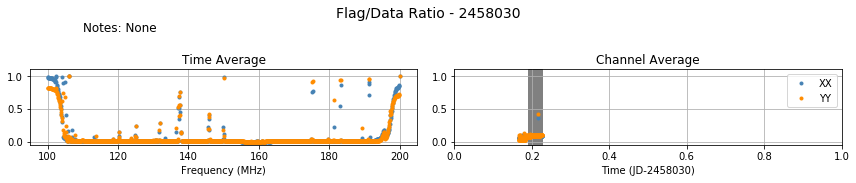

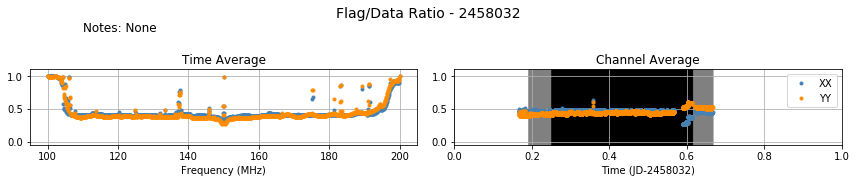

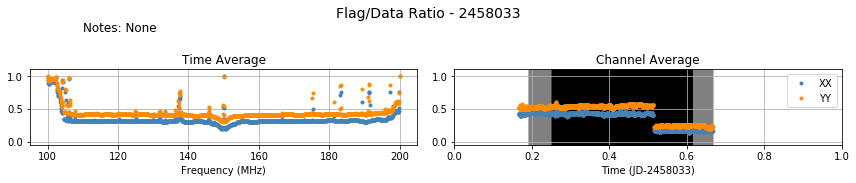

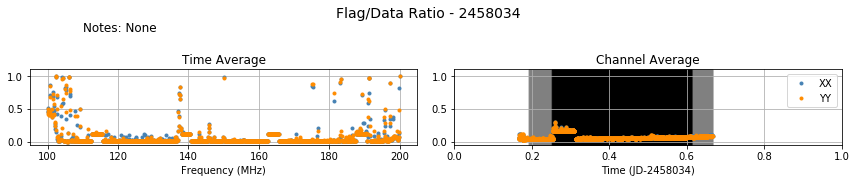

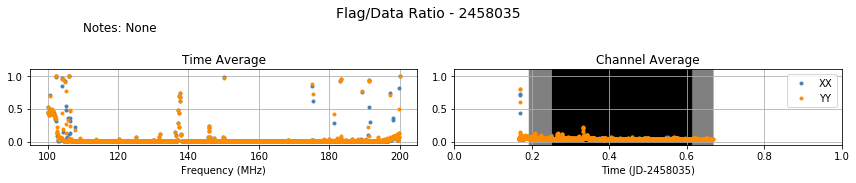

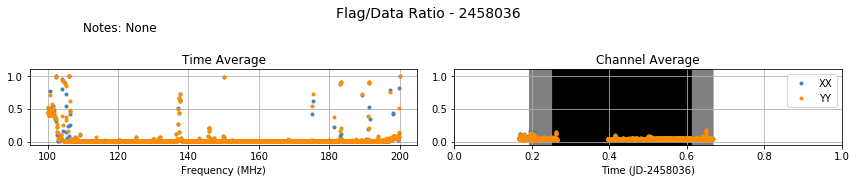

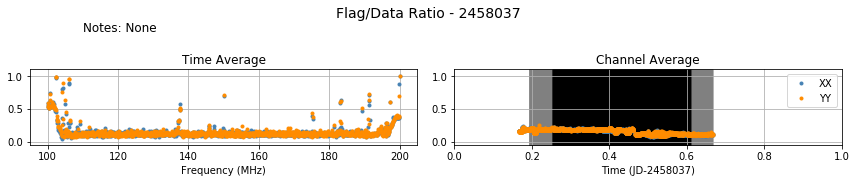

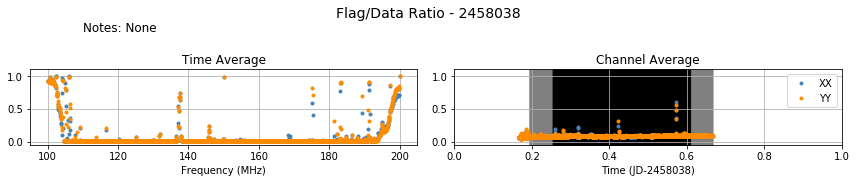

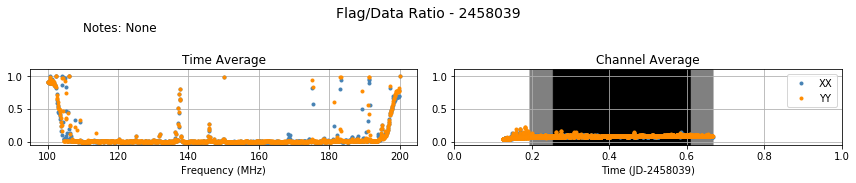

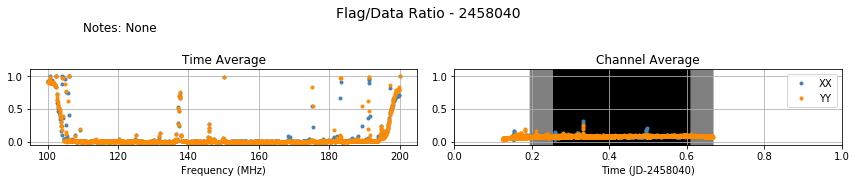

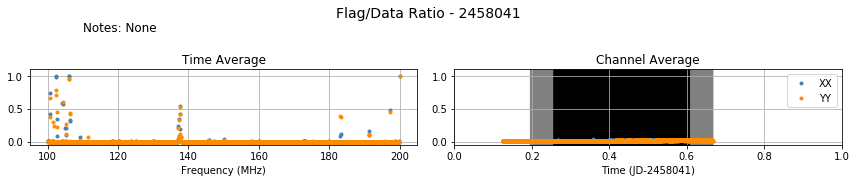

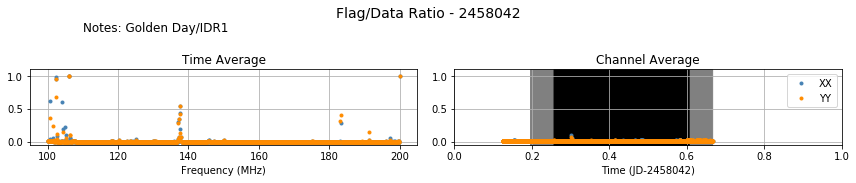

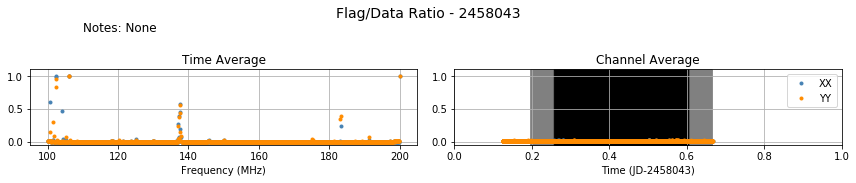

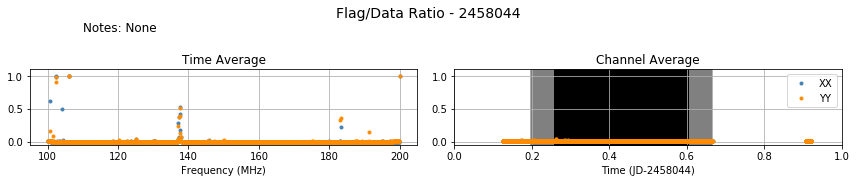

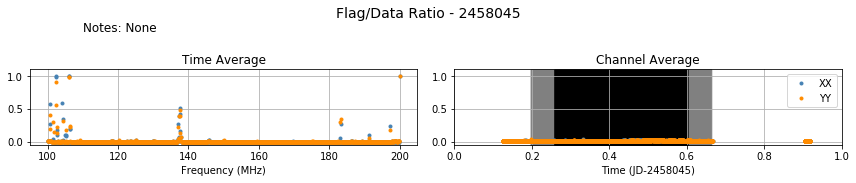

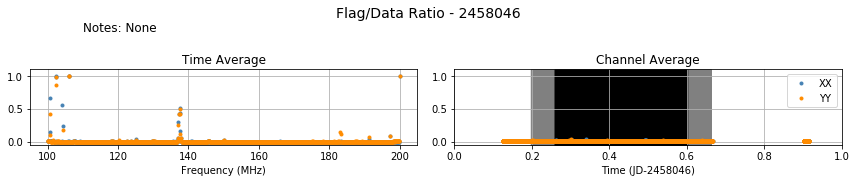

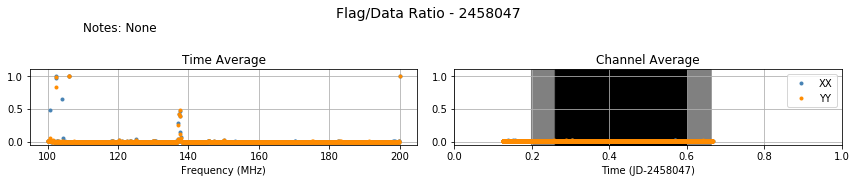

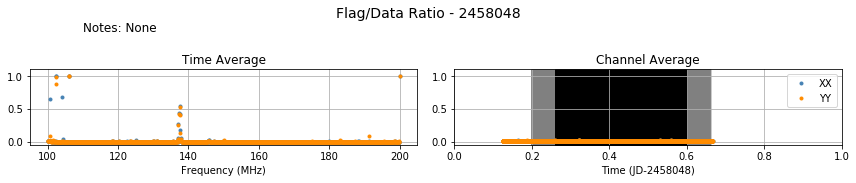

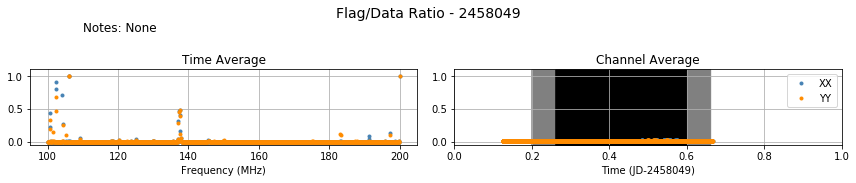

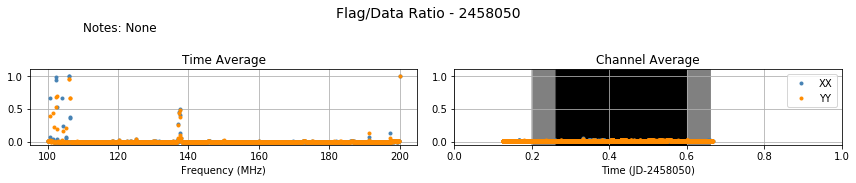

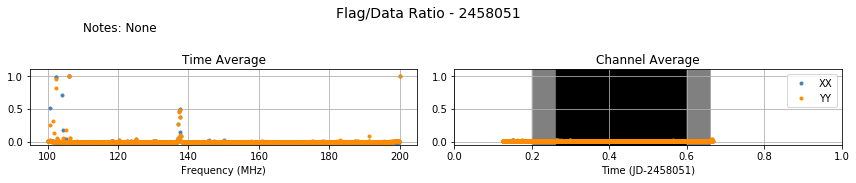

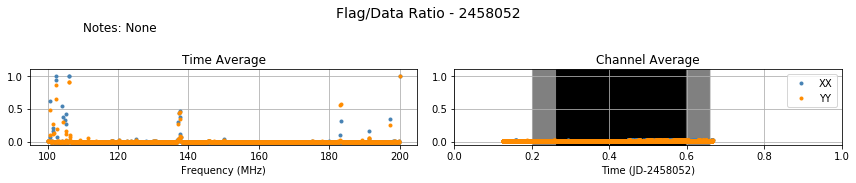

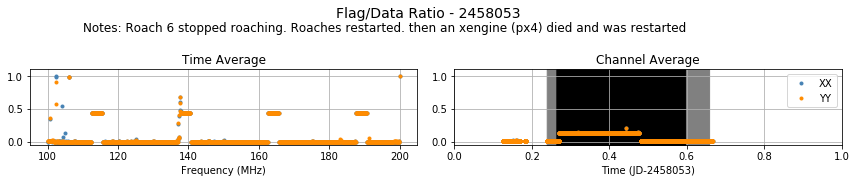

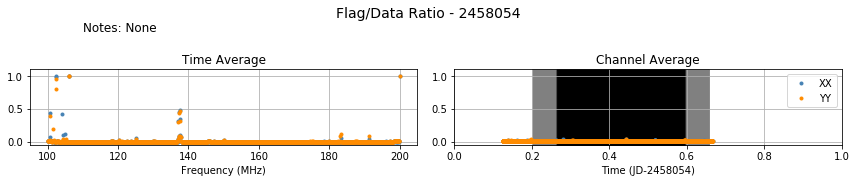

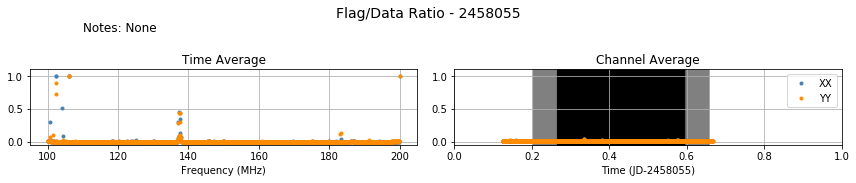

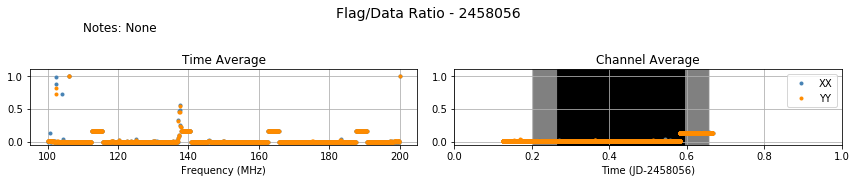

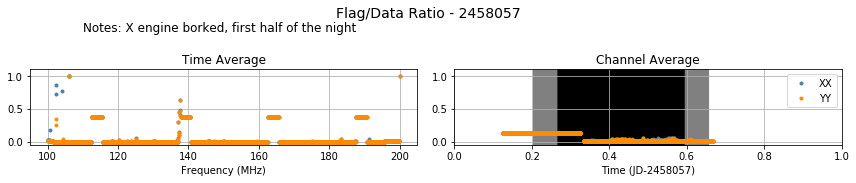

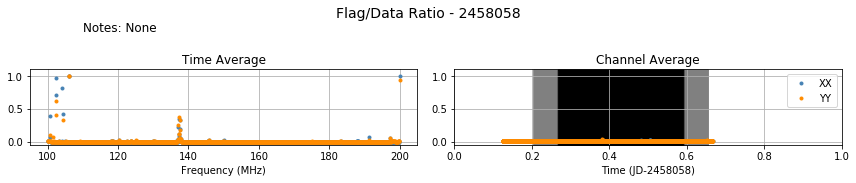

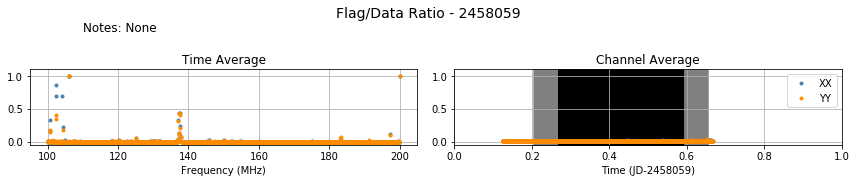

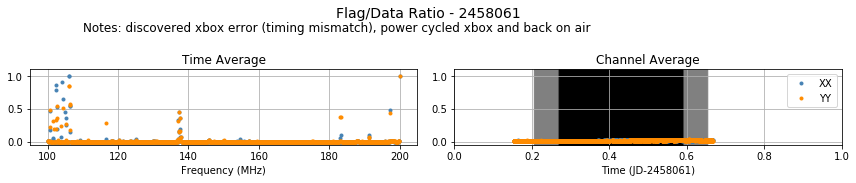

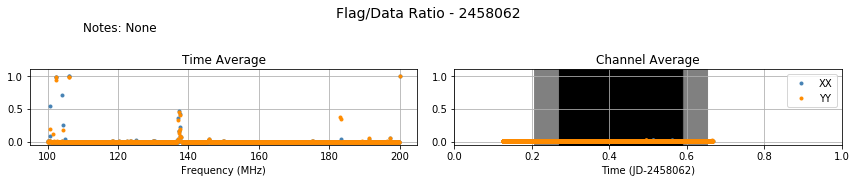

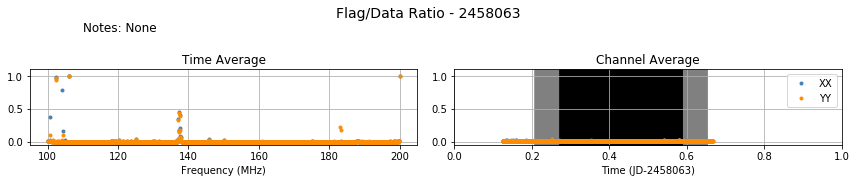

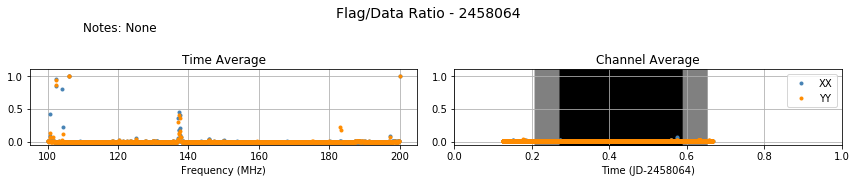

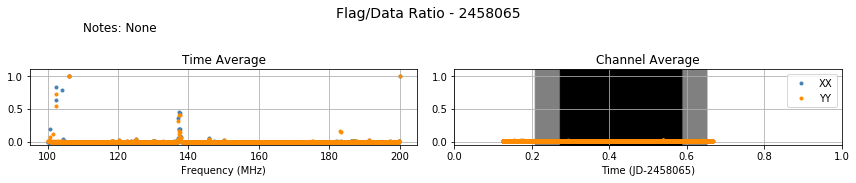

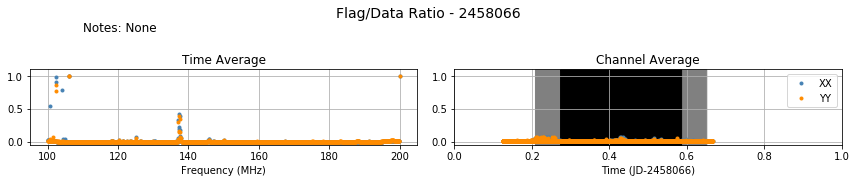

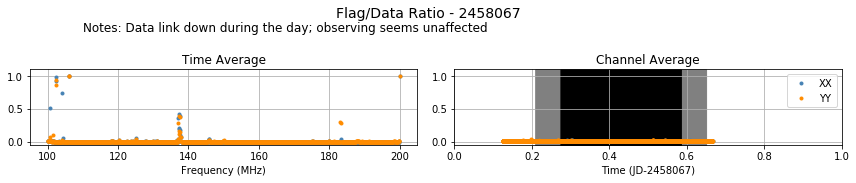

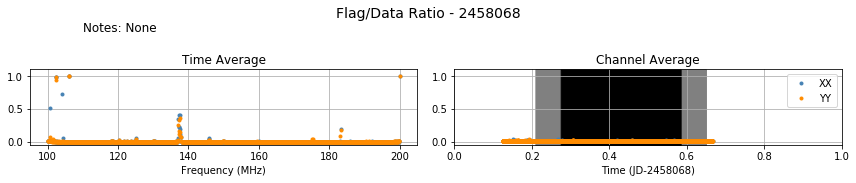

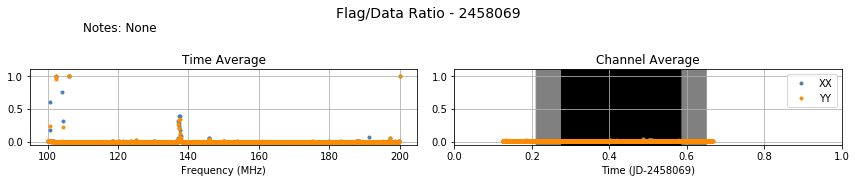

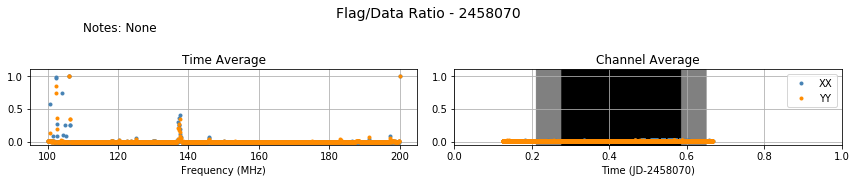

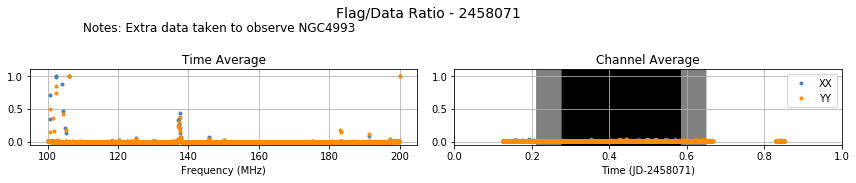

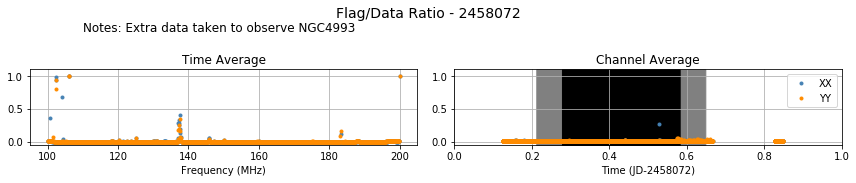

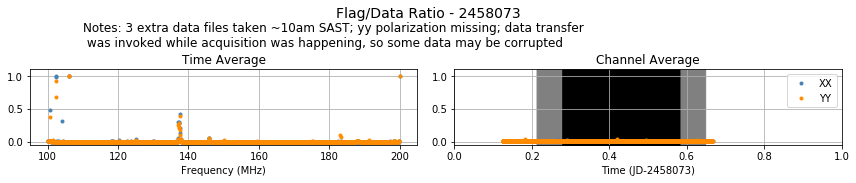

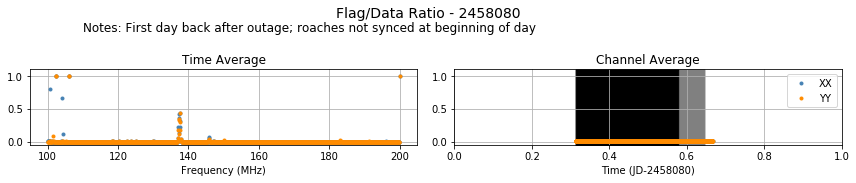

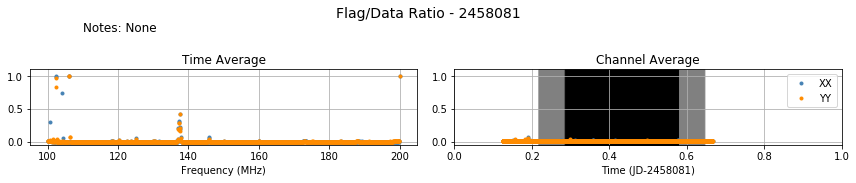

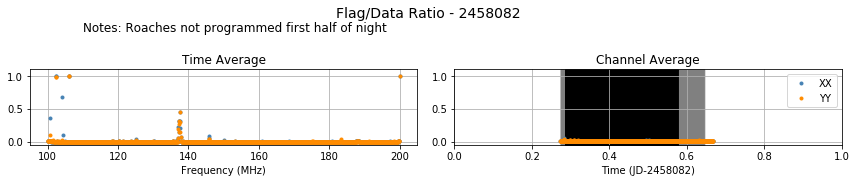

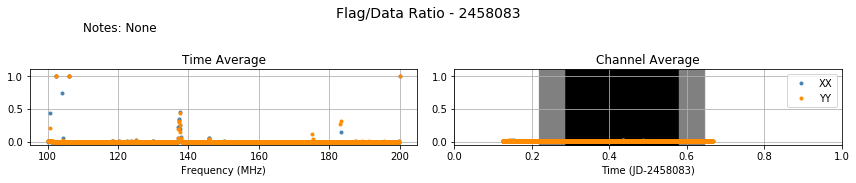

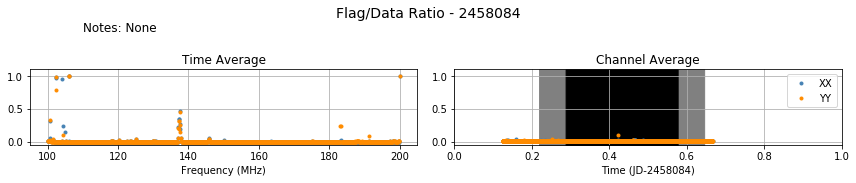

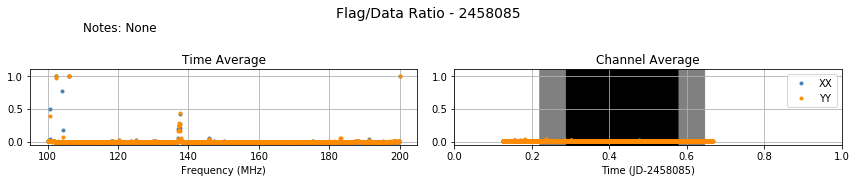

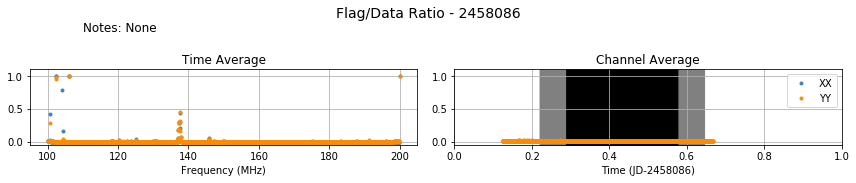

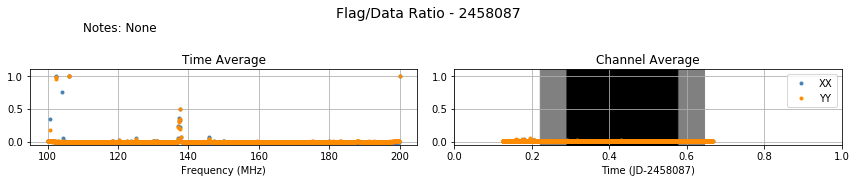

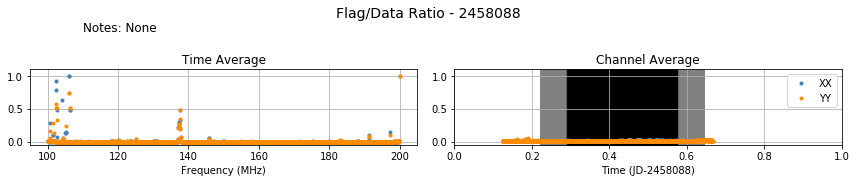

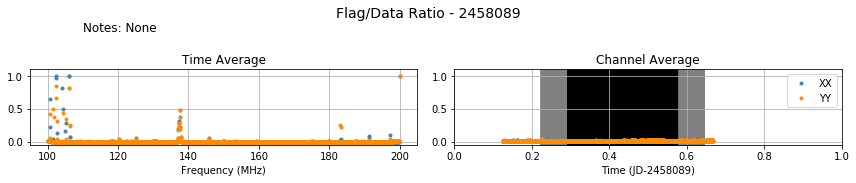

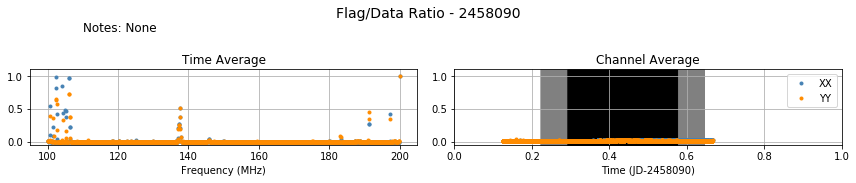

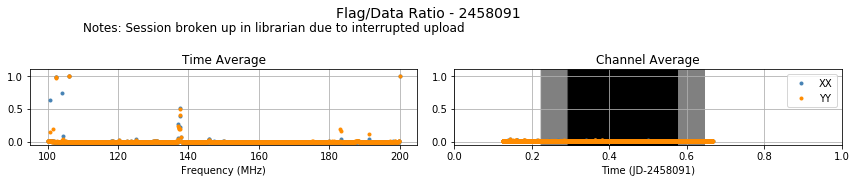

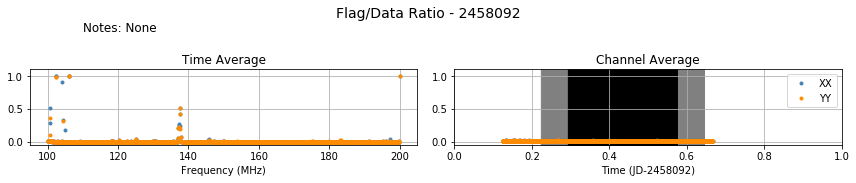

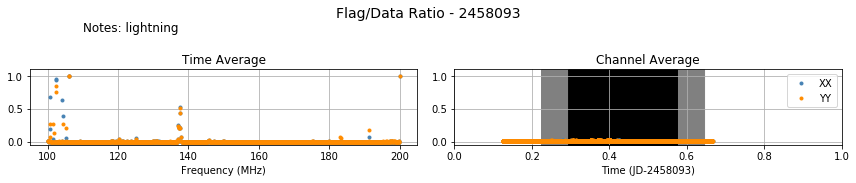

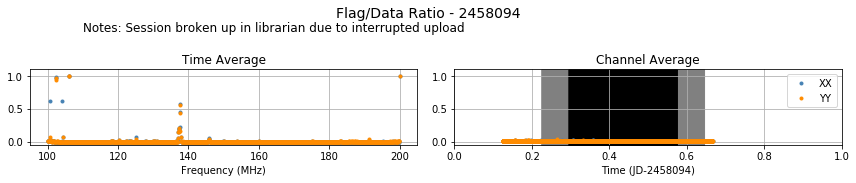

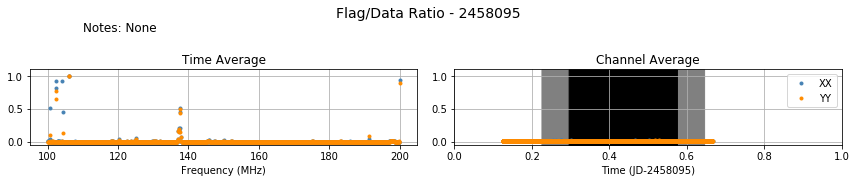

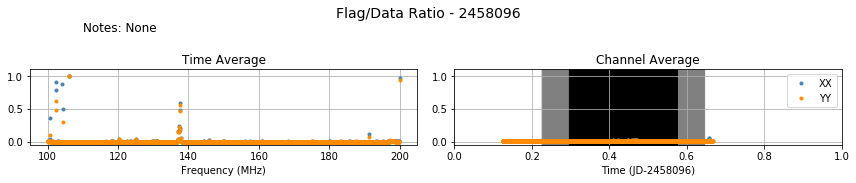

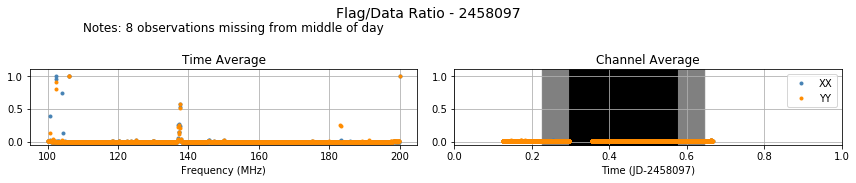

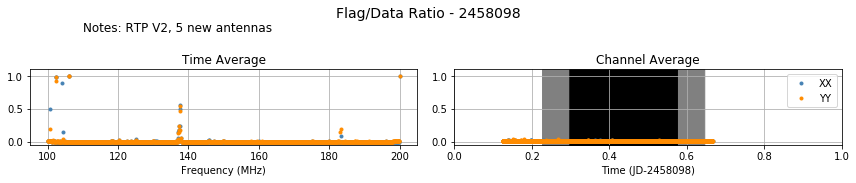

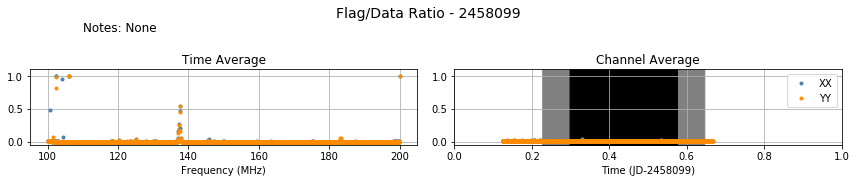

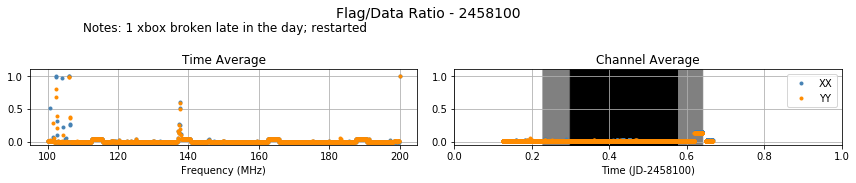

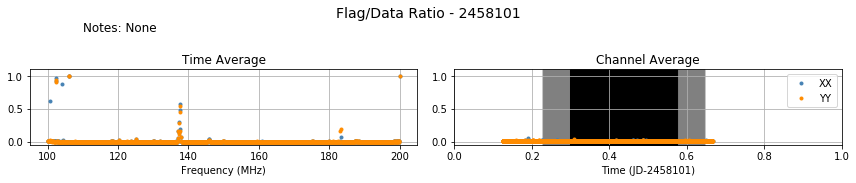

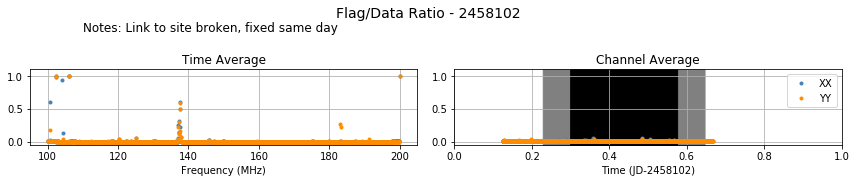

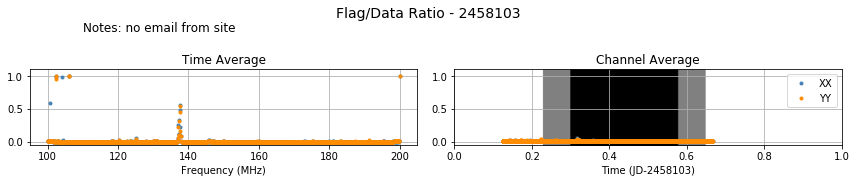

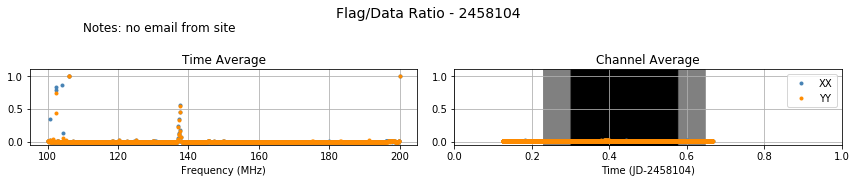

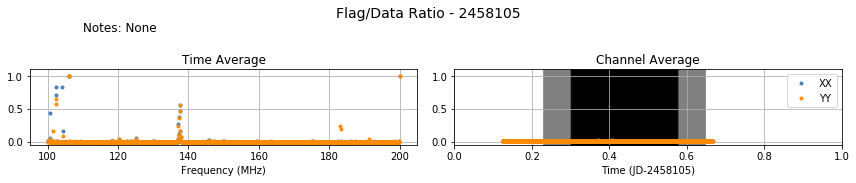

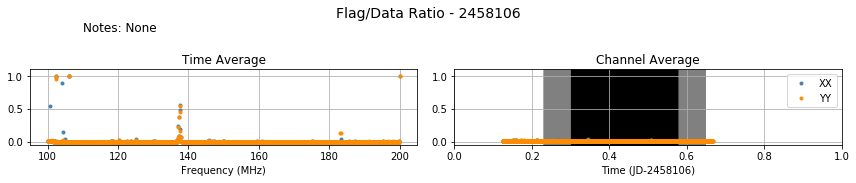

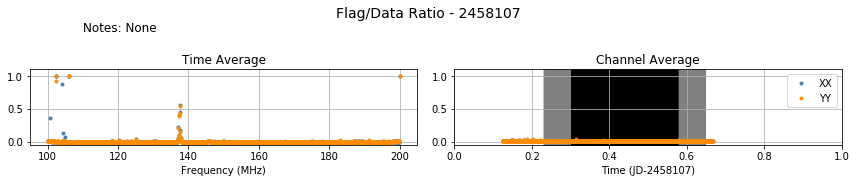

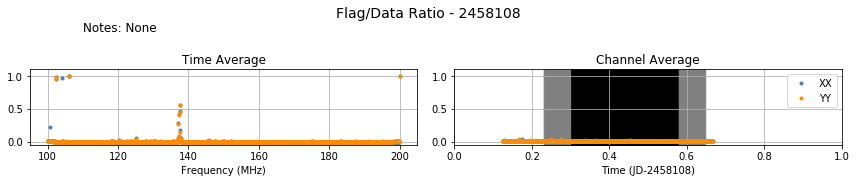

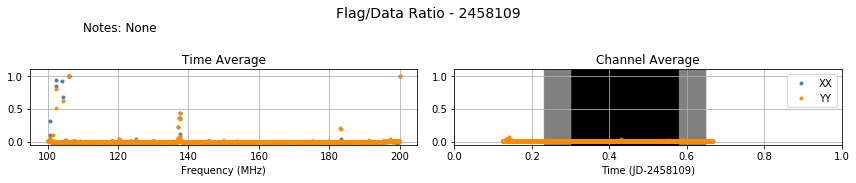

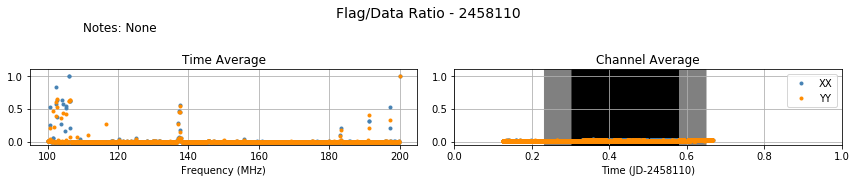

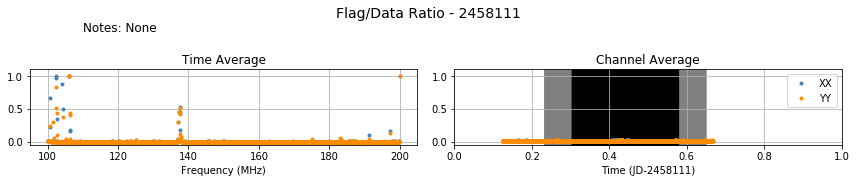

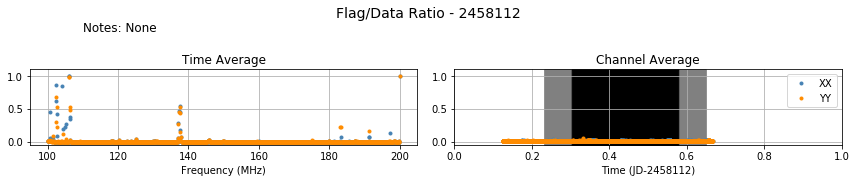

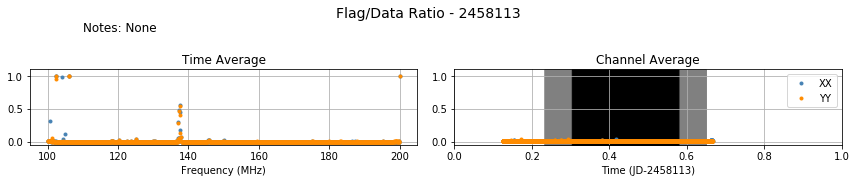

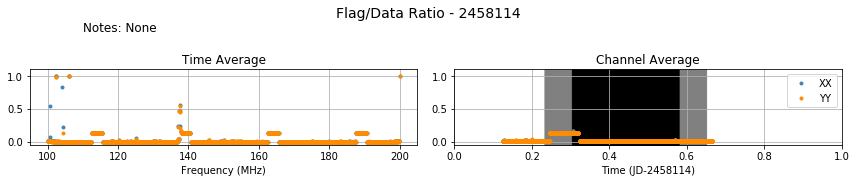

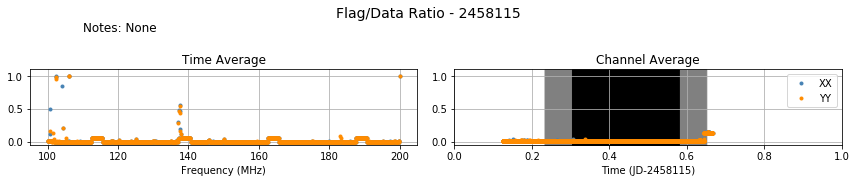

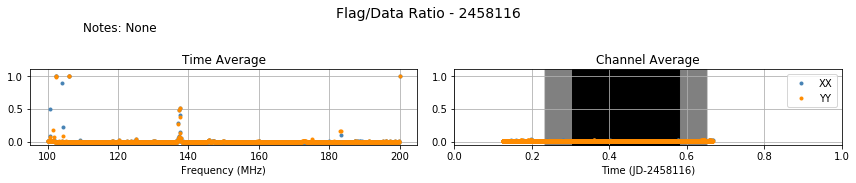

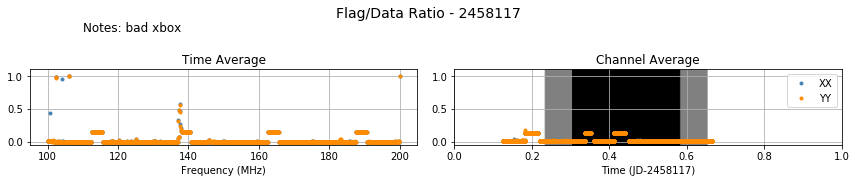

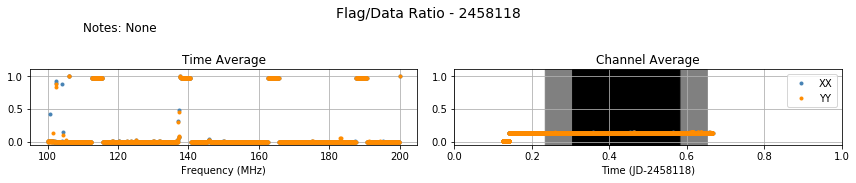

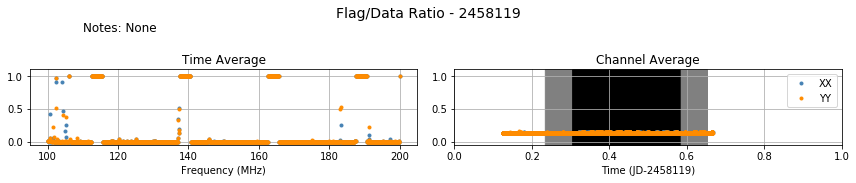

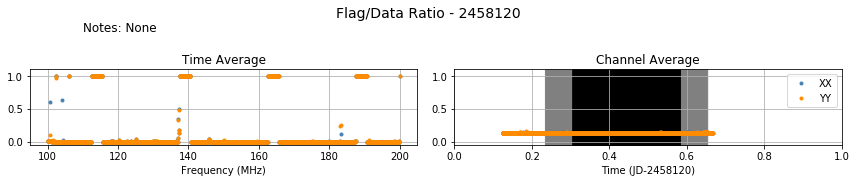

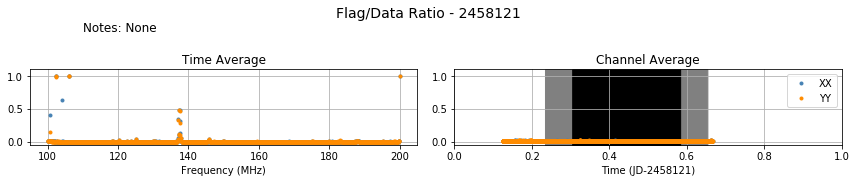

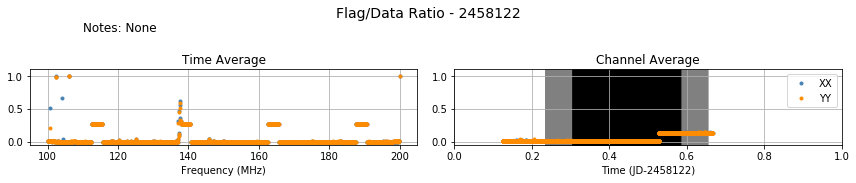

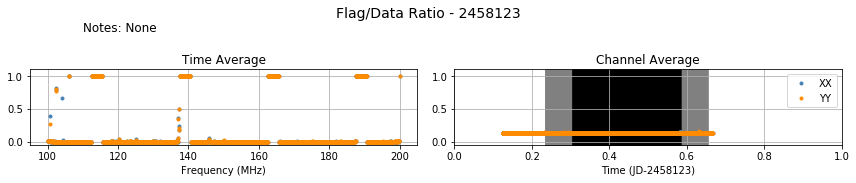

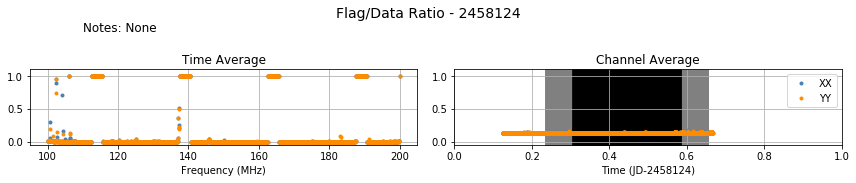

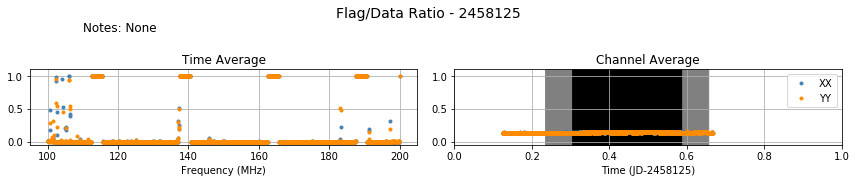

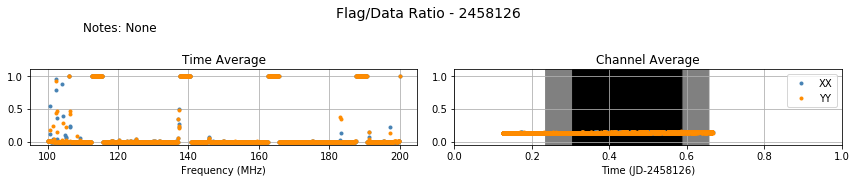

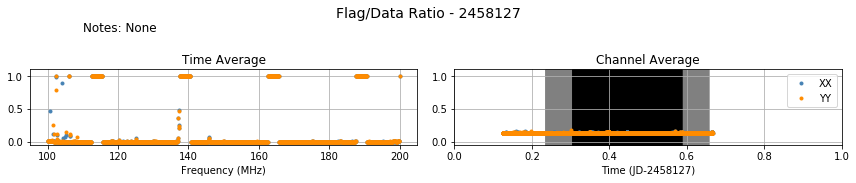

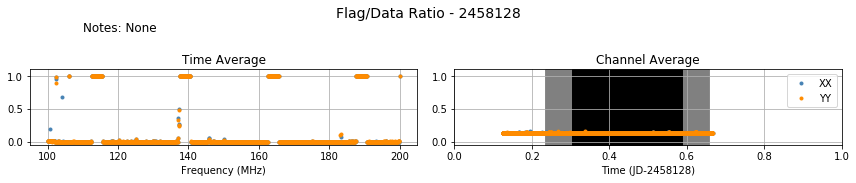

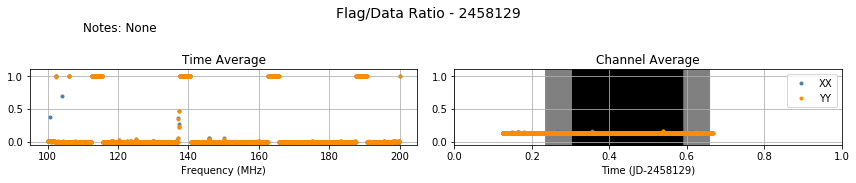

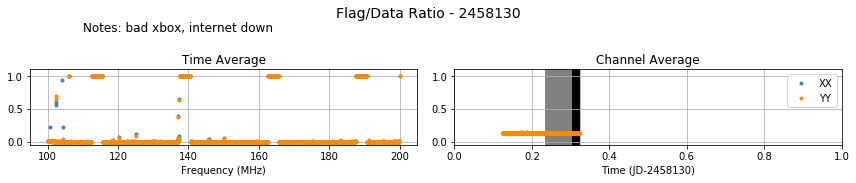

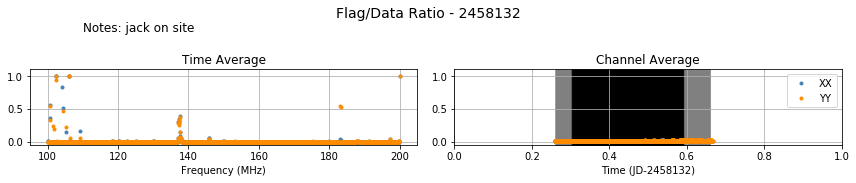

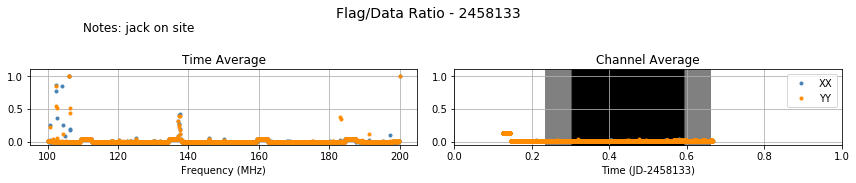

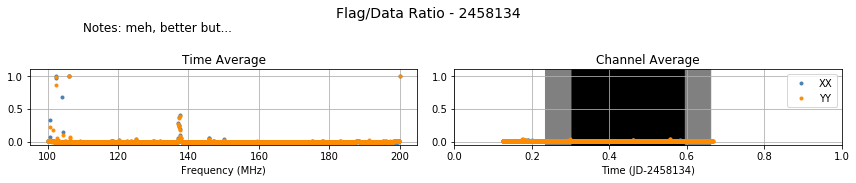

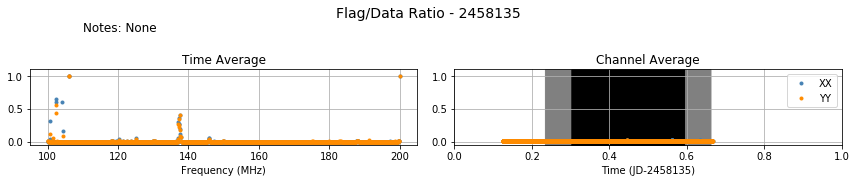

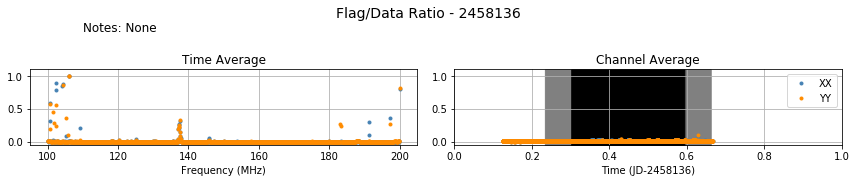

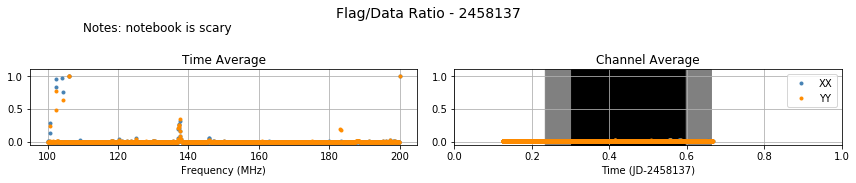

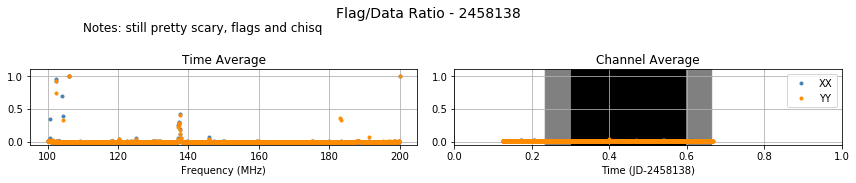

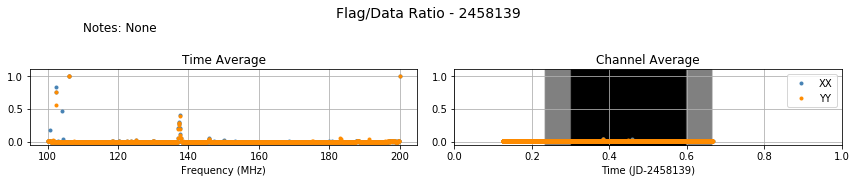

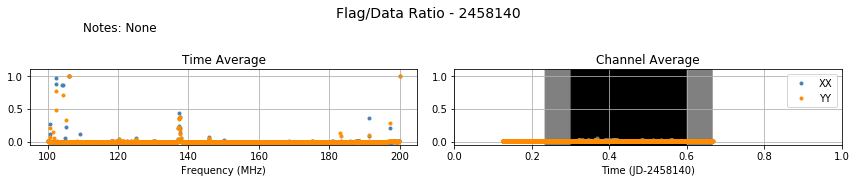

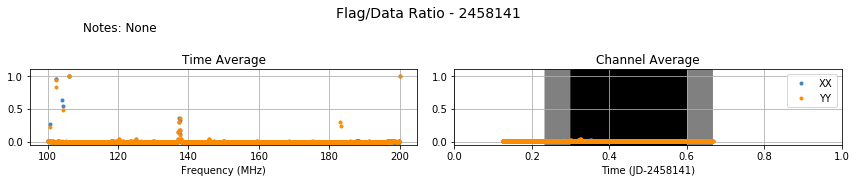

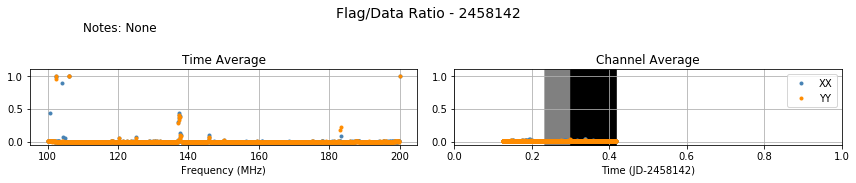

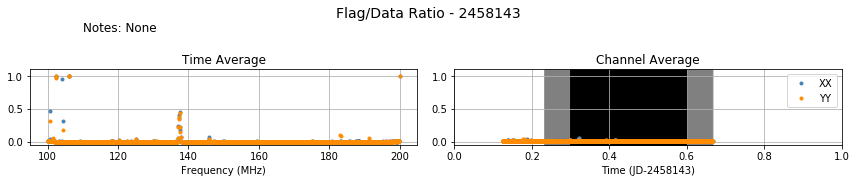

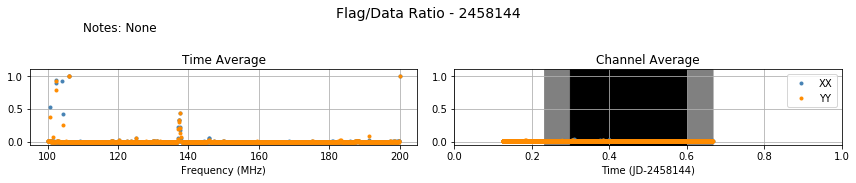

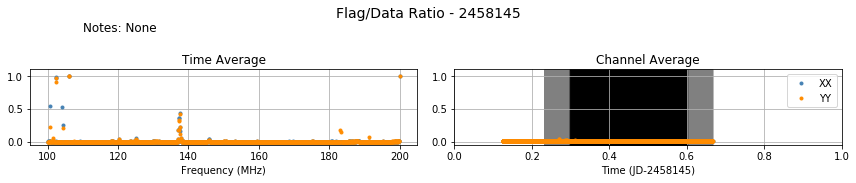

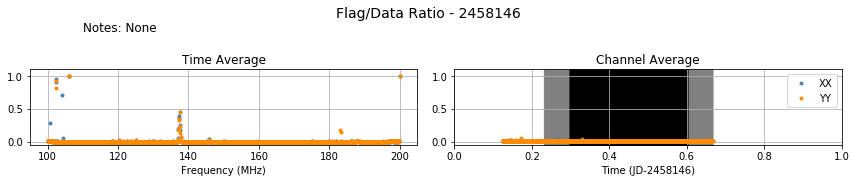

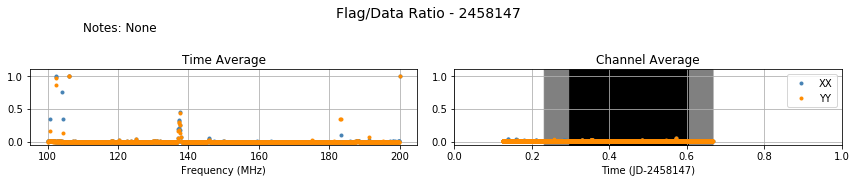

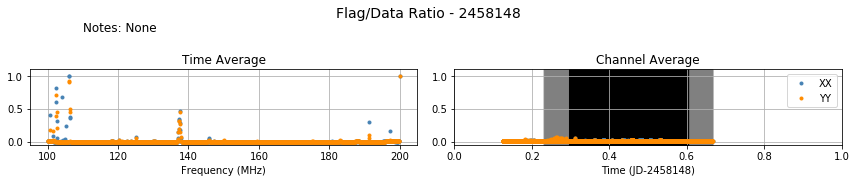

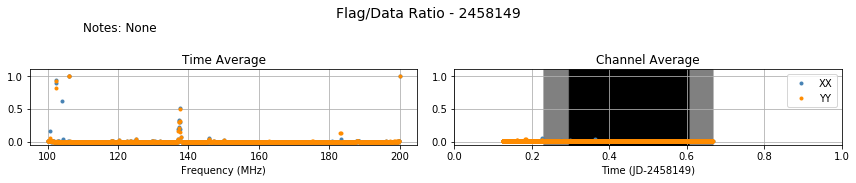

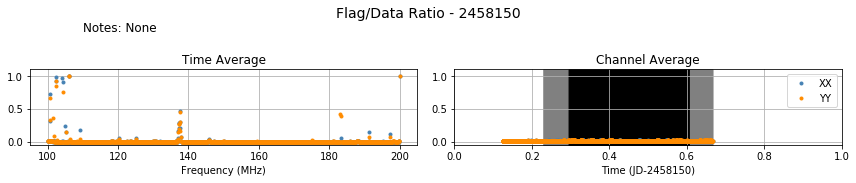

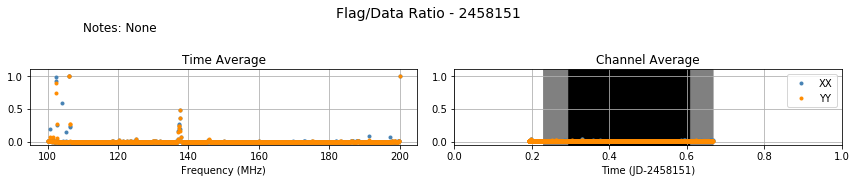

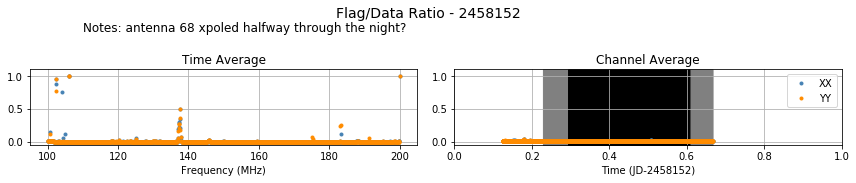

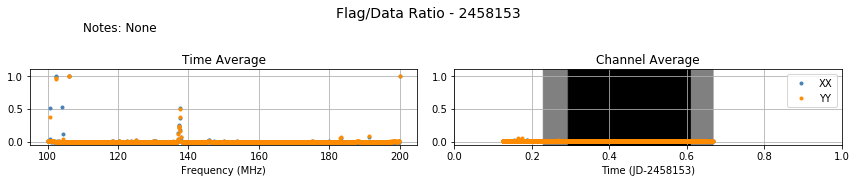

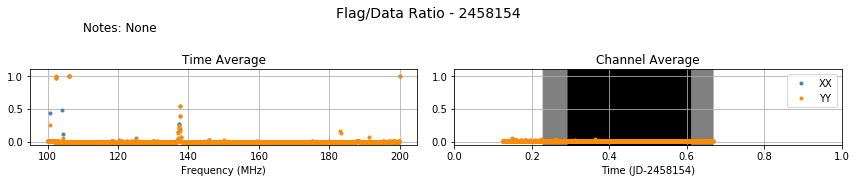

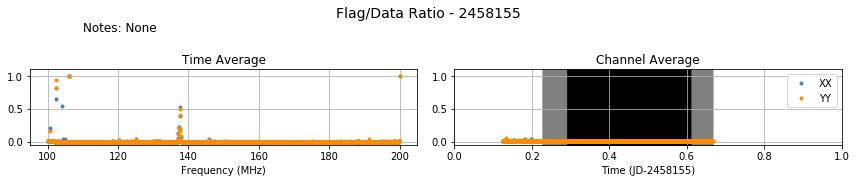

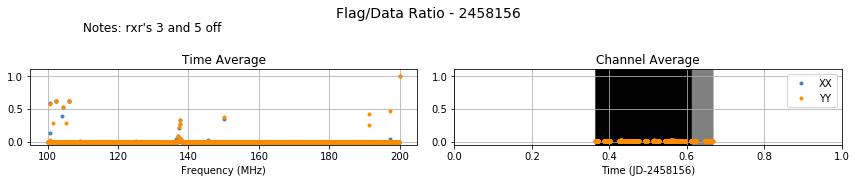

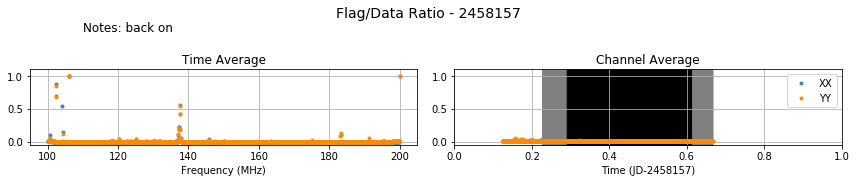

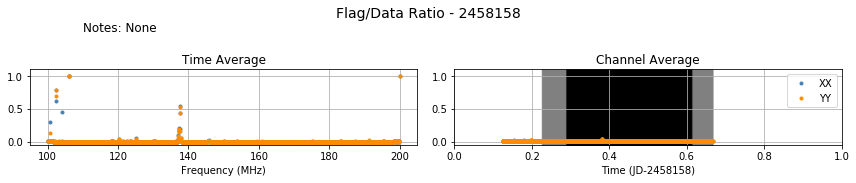

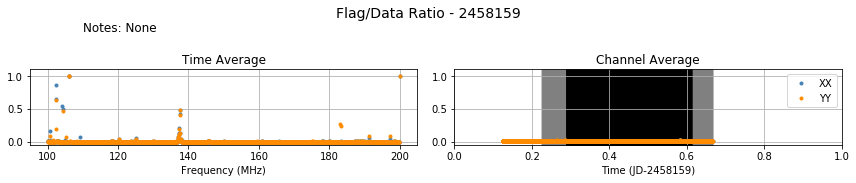

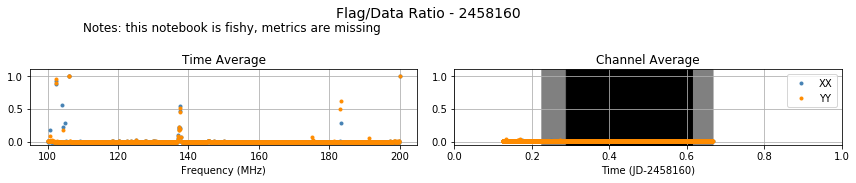

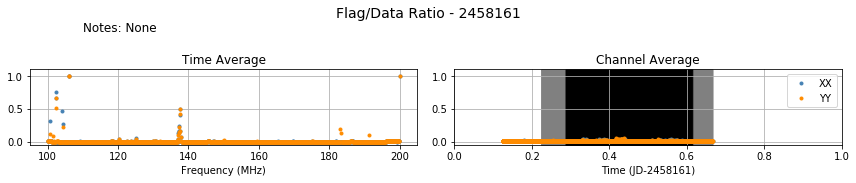

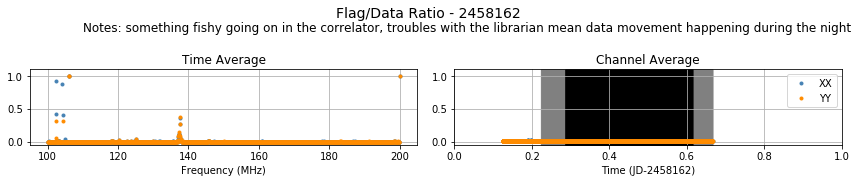

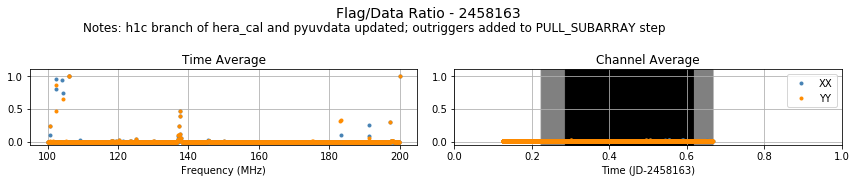

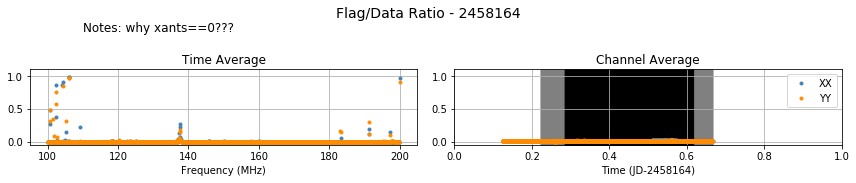

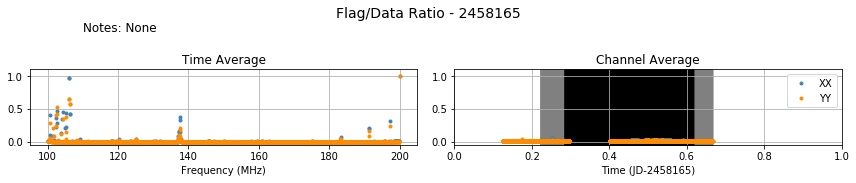

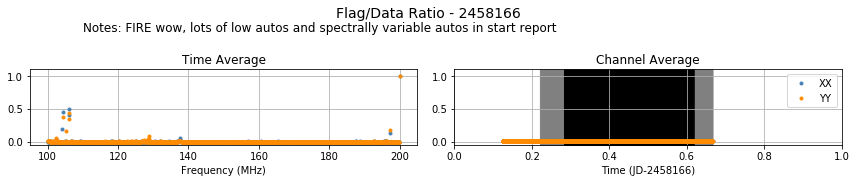

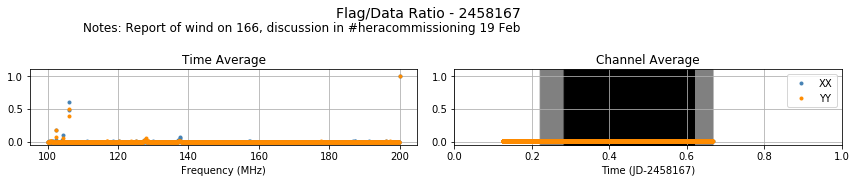

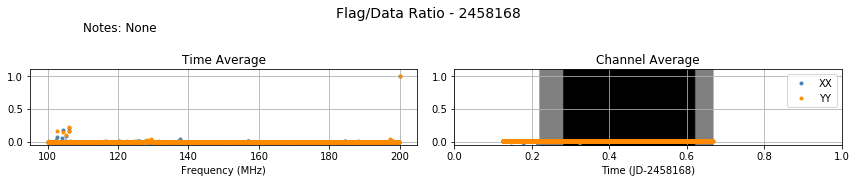

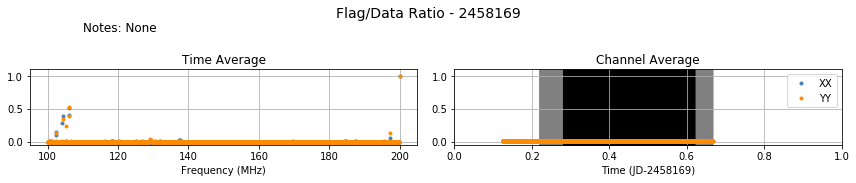

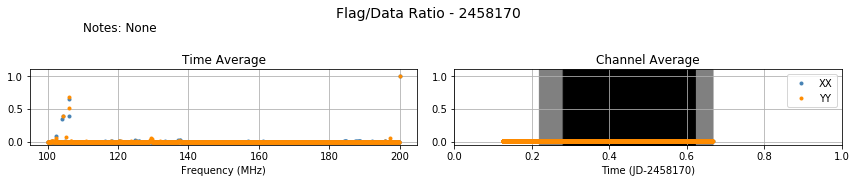

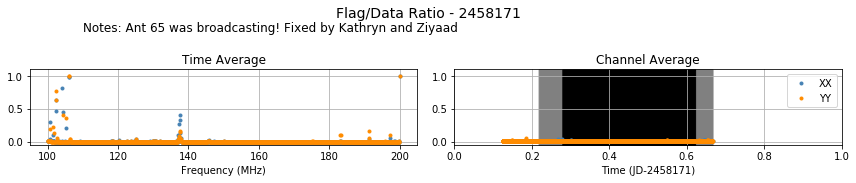

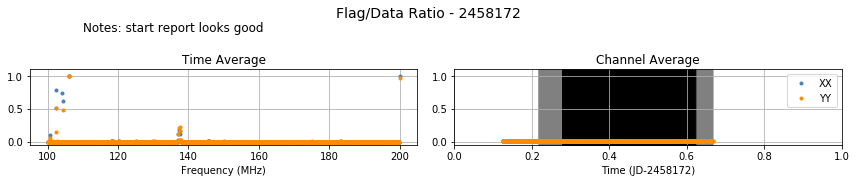

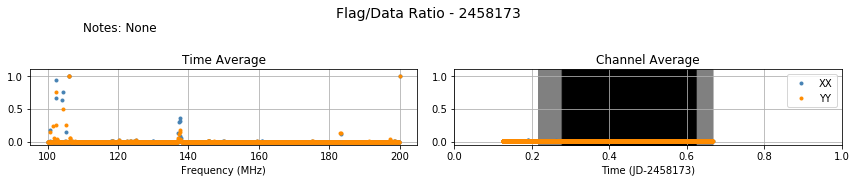

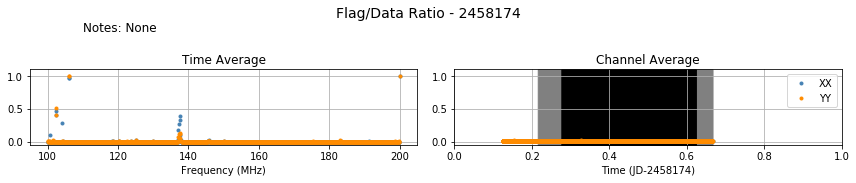

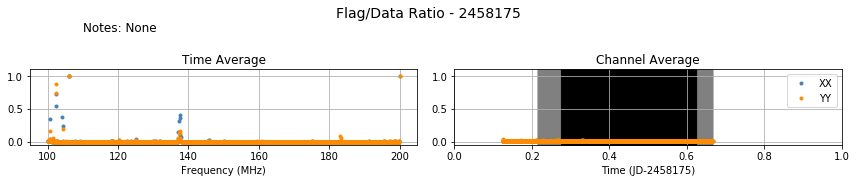

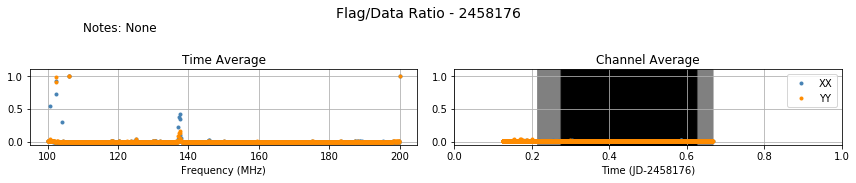

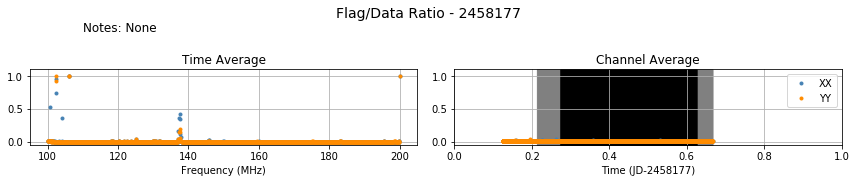

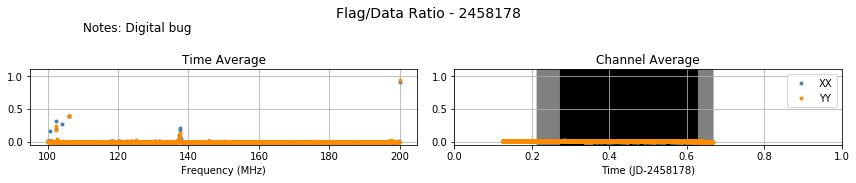

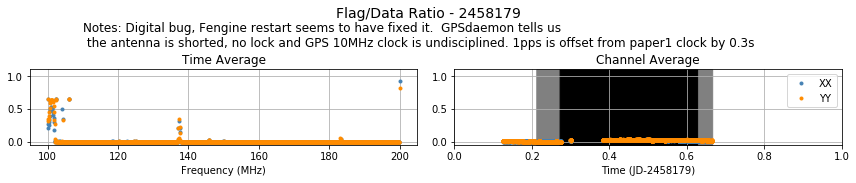

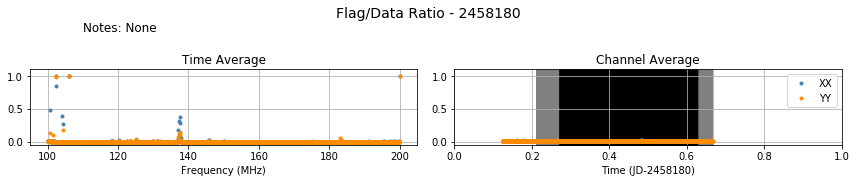

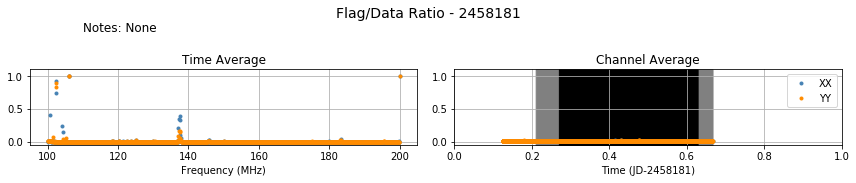

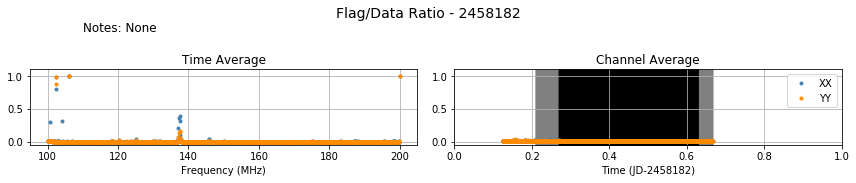

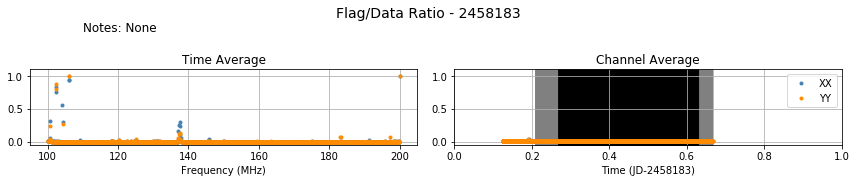

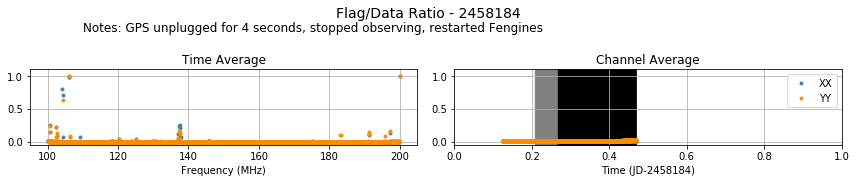

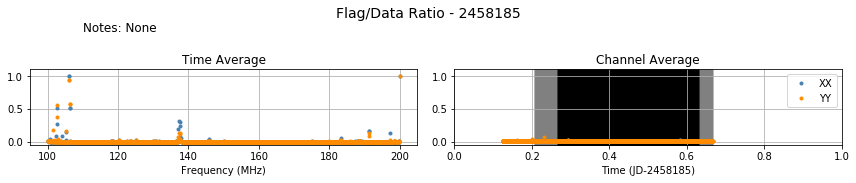

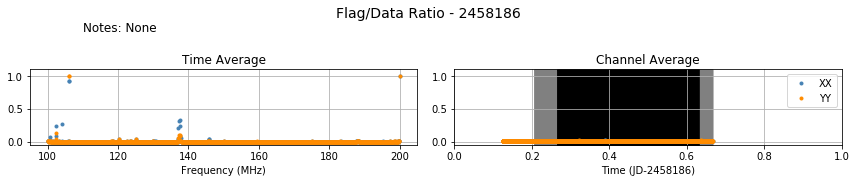

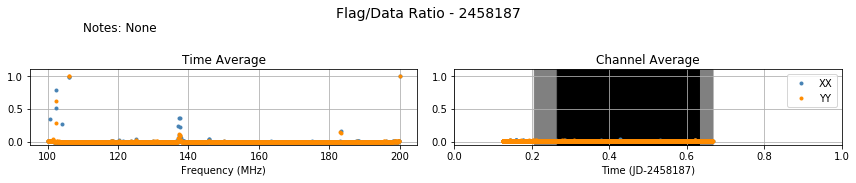

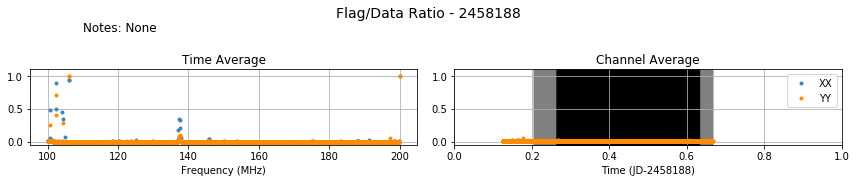

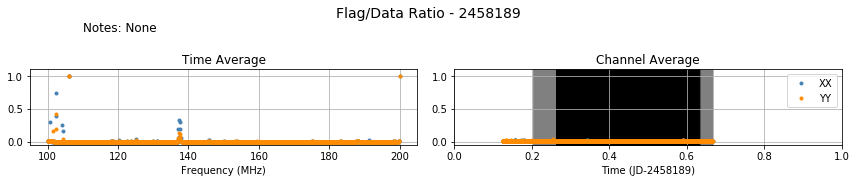

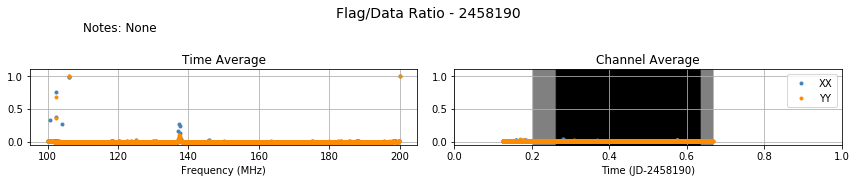

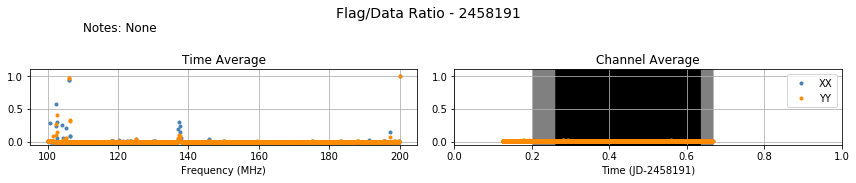

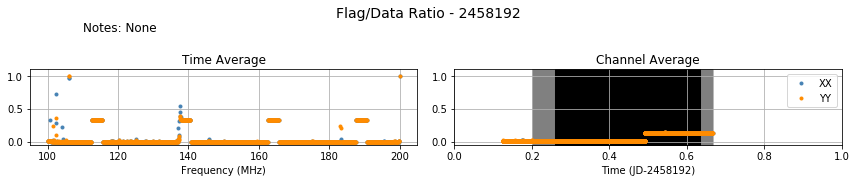

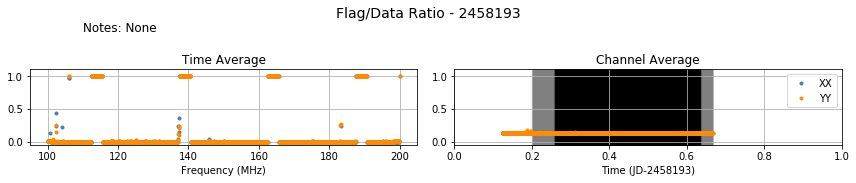

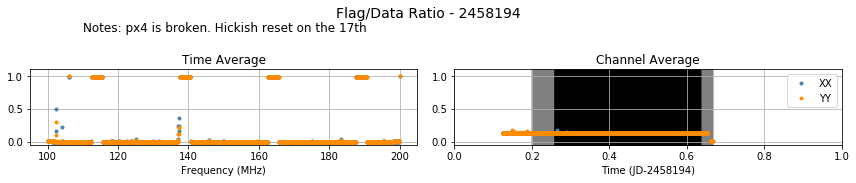

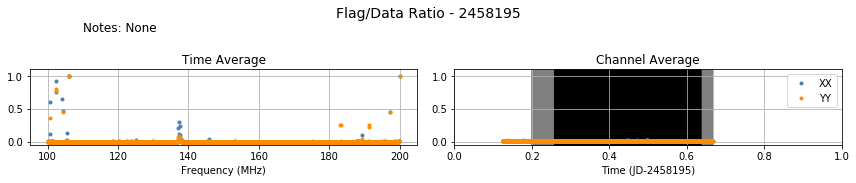

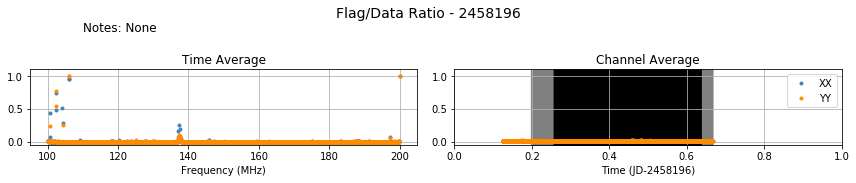

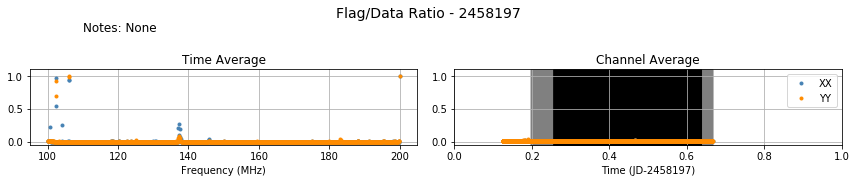

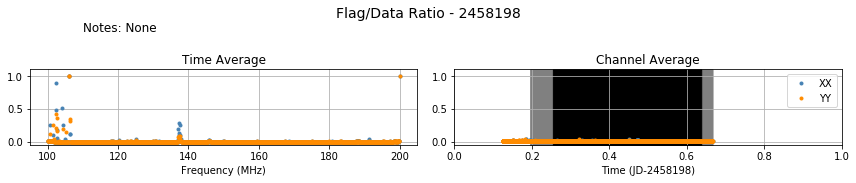

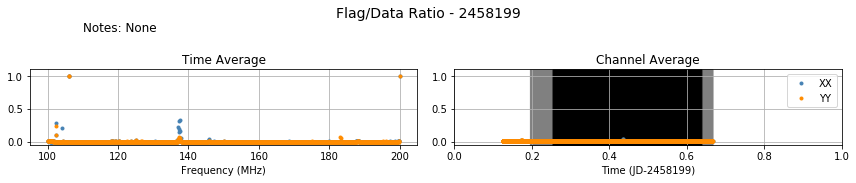

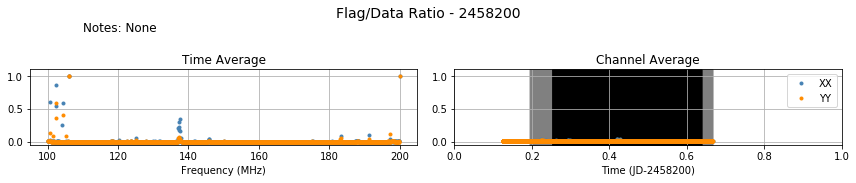

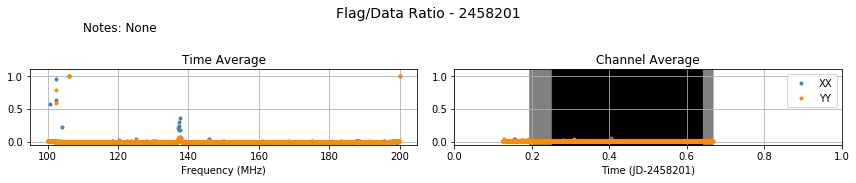

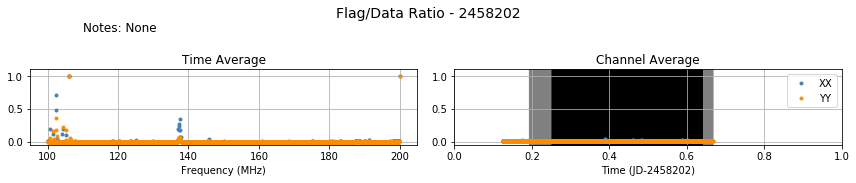

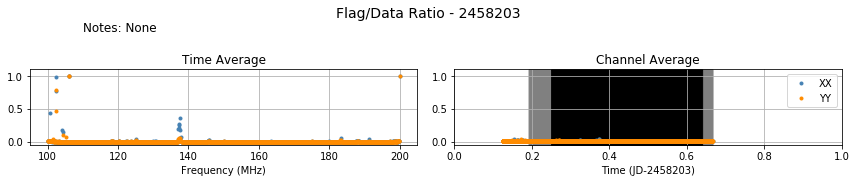

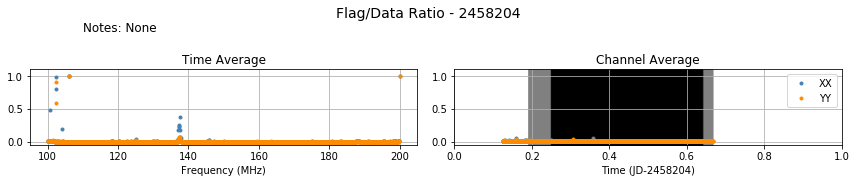

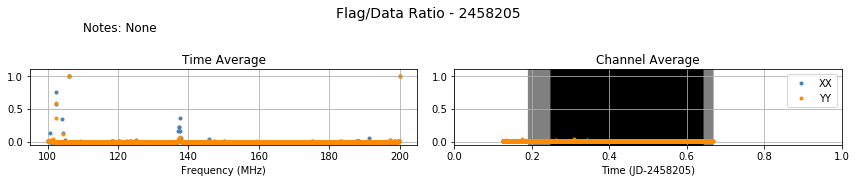

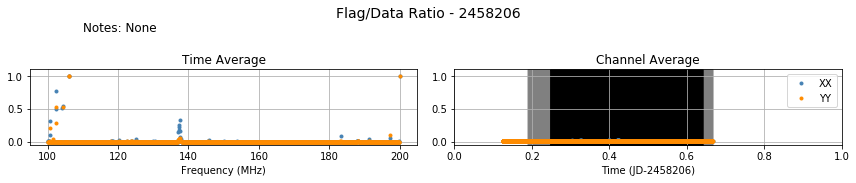

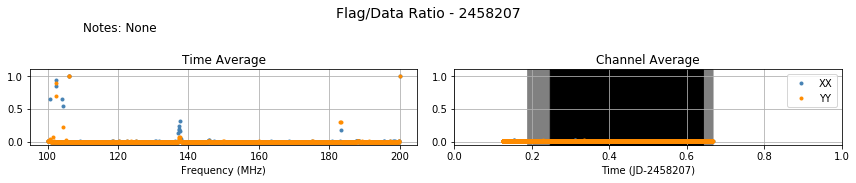

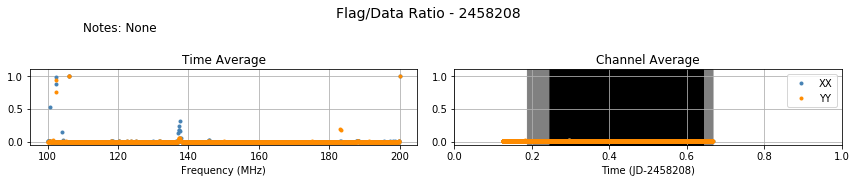

In [149]:
chantrail=np.zeros((numplts, 1024))
freqs=np.linspace(100, 200, num=1024)
#plt.suptitle('Flag/Data Ratio - ' + os.path.split(DATA_PATH)[1]+' (flags_summary.npz) (baseline averaged)', y=1.05, fontsize=18)
    #Generate time averaged plots:
for i, flagfile in enumerate(plot_files):
    
    plot_arrays=np.load(flagfile)
    #freqtrail[i]=plot_arrays['chan_mean_xx']    
    fig=plt.figure(figsize=(12,2))
    plt.suptitle('Flag/Data Ratio - ' + os.path.split(flagfile)[1][:7], y=1.25, fontsize=14)
    plt.figtext(.1,1.15,'Notes: ' + notes[i][1], fontsize=12,verticalalignment='top')

    ax=fig.add_subplot(1,2,1)

    ax.grid()
    
    ax.set_ylim(-.05,1.1)
    if int(os.path.split(flagfile)[1][:7])>2458040:
        chantrail[i]=plot_arrays['time_mean_xx']
        ax.plot(freqs,plot_arrays['time_mean_xx'], color='steelblue', marker='.', ls='', label='XX')
        ax.plot(freqs,plot_arrays['time_mean_yy'], color='darkorange', marker='.', ls='', label='YY')
    else:
        chantrail[i]=plot_arrays['time_mean_xx_old']
        ax.plot(freqs,plot_arrays['time_mean_xx_old'], color='steelblue', marker='.', ls='', label='XX')
        ax.plot(freqs,plot_arrays['time_mean_yy_old'], color='darkorange', marker='.', ls='', label='YY')
        
    ax.set_xlabel('Frequency (MHz)')
    plt.title('Time Average')
    plt.tight_layout()
    
    
    #Frequency averaged plot
    arrlen=len(plot_arrays['chan_mean_xx'])
    xlim=4380 if (arrlen<4380) else arrlen
    ax2=fig.add_subplot(1,2,2)
    ax2.grid()
    ax2.set_xlim(0, 1)
    #ax2.set_xlim(0, xlim)
    ax2.set_ylim(-0.05,1.1)
    if int(os.path.split(flagfile)[1][:7])>2458040:
        ax2.plot(plot_arrays['flag_times_xx']-int(notes[i][0]),plot_arrays['chan_mean_xx'], color='steelblue', marker='.', ls='',label='XX')
        ax2.plot(plot_arrays['flag_times_yy']-int(notes[i][0]),plot_arrays['chan_mean_yy'], color='darkorange', marker='.', ls='',label='YY')
    else:
        ax2.plot(plot_arrays['flag_times_xx']-int(notes[i][0]),plot_arrays['chan_mean_xx_old'], color='steelblue', marker='.', ls='',label='XX')
        ax2.plot(plot_arrays['flag_times_yy']-int(notes[i][0]),plot_arrays['chan_mean_yy_old'], color='darkorange', marker='.', ls='',label='YY')
        
    ax2.fill_between(plot_arrays['flag_times_xx']-int(notes[i][0]), -1.1, 1.1, sunAltAz[i].alt < -0*u.deg, color='0.5', zorder=0)
    ax2.fill_between(plot_arrays['flag_times_xx']-int(notes[i][0]), -1.1, 1.1, sunAltAz[i].alt < -18*u.deg, color='black', zorder=1)
    ax2.set_xlabel('Time (JD-'+notes[i][0]+')' )
    
    ax2.legend()
    plt.title('Channel Average')
    

    
    plt.tight_layout()
    plt.show()



Below is an input cell that will allow you to more closely inspect the plots associated with a given JD.

Please enter the desired JD of your observation as a 7 digit integer(eg. 2458042): 2458140


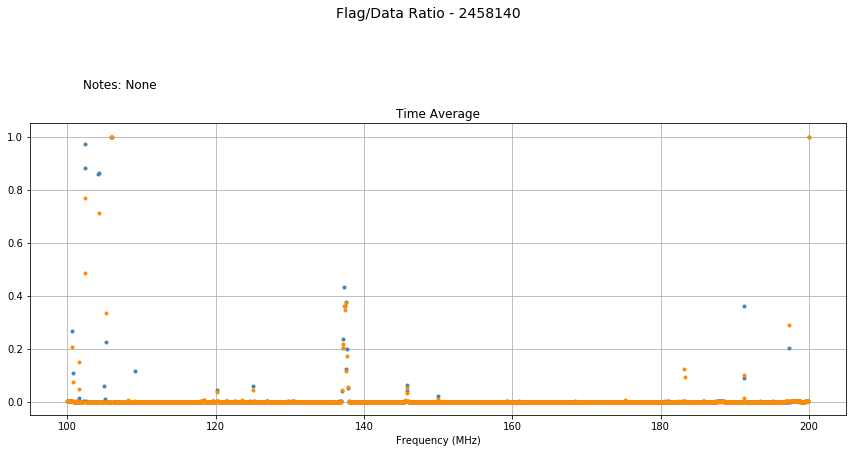

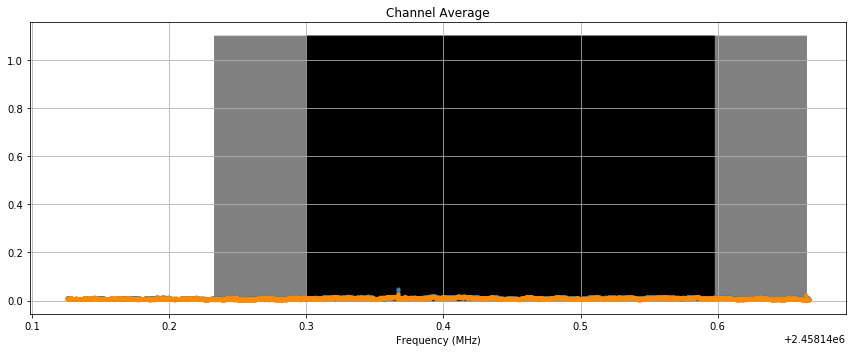

In [73]:
#code to inspect a particular file from user input
while True:
    jd_to_inspect=raw_input('Please enter the desired JD of your observation as a 7 digit integer(eg. 2458042): ')
    if any(jd_to_inspect in sublist for sublist in notes):
        break
    else:
        print ('Invalid JD, please enter the desired JD as a 7 digit integer(eg. 2458042): ')
    
    
file_to_inspect=np.load(DATA_PATH + '/'+jd_to_inspect+'_plot_arrays.npz')

fig=plt.figure(figsize=(12,5))
# plt.style.use('dark_background')
fig.subplots_adjust(hspace=2)
plt.suptitle('Flag/Data Ratio - ' + jd_to_inspect, y=1.25, fontsize=14)
singlenote=[notes[i][1] for i,note in enumerate(notes) if notes[i][0]==jd_to_inspect]
singlesun=[sunAltAz[i] for i, note in enumerate(notes) if notes[i][0]==jd_to_inspect]
plt.figtext(.1,1.05,'Notes: ' + singlenote[0], fontsize=12,verticalalignment='top')

ax=fig.add_subplot(1,1,1)
#load this particular file

ax.grid()
# ax.set_ylim(-0.2,1.1)
ax.plot(freqs,file_to_inspect['time_mean_xx'], color='steelblue', marker='.', ls='')
ax.plot(freqs,file_to_inspect['time_mean_yy'], color='darkorange', marker='.', ls='')
ax.set_xlabel('Frequency (MHz)')

plt.title('Time Average')
plt.tight_layout()

#Frequency averaged plot
fig=plt.figure(figsize=(12,5))
arrlen=len(plot_arrays['chan_mean_xx'])
xlim=4380 if (arrlen<4380) else arrlen
ax2=fig.add_subplot(1,1,1)
ax2.grid()
# ax2.set_xlim(0, 4380)
# ax2.set_xlim(0, xlim)
# ax2.set_ylim(-0.2,1.1)
ax2.plot(file_to_inspect['flag_times_xx'],file_to_inspect['chan_mean_xx'], color='steelblue', marker='.', ls='')
ax2.plot(file_to_inspect['flag_times_yy'],file_to_inspect['chan_mean_yy'], color='darkorange', marker='.', ls='')
ax2.fill_between(file_to_inspect['flag_times_xx'], 0, 1.1, singlesun[0].alt < -0*u.deg, color='0.5', zorder=0)
ax2.fill_between(file_to_inspect['flag_times_xx'], 0, 1.1, singlesun[0].alt < -18*u.deg, color='black', zorder=1)
ax2.set_xlabel('Frequency (MHz)')

plt.title('Channel Average')
plt.tight_layout()
plt.show()

It was suggested that the above plots could be turned into a frequency trail (or Joyplot, after the Joy Division record with a frequency trail album cover), which gives a more visual representation of change between plots. To the right of these time-average plots, a daily average is calculated and plotted. Both plots move from top to bottom, increasing in time.

The red line in the daily average represents a 0.2 ratio of flags. This is being considered as an initial cutoff when deciding which observations to include for the upcoming IDR3 release. Also in the cells below are a copyable table of these daily values as well as a histogram showing the distribution of them.

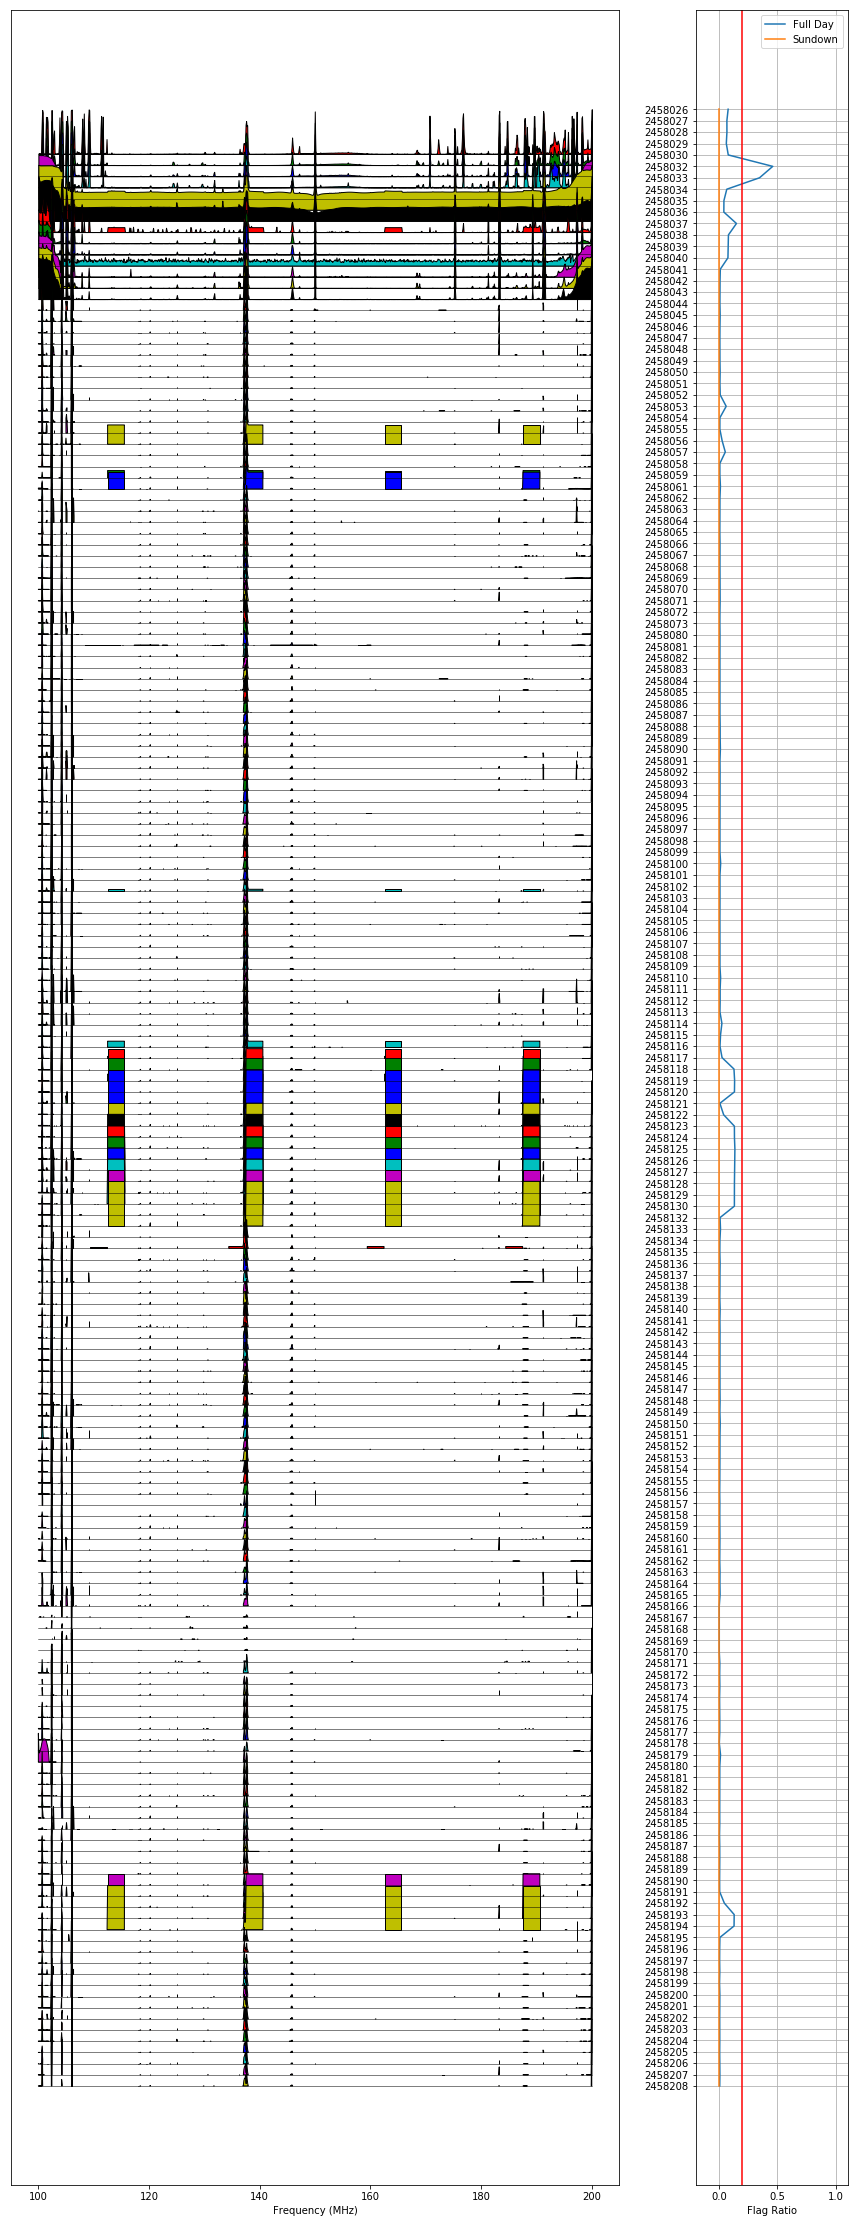

In [150]:
#set displacement for joy plot
displace = (.25)
chans=np.linspace(0,1024,1024)
# Add a cutoff
chantrail[chantrail<=0] = None

face_colors = itertools.cycle(['r','g','b','c','m','y','k']) #rotate through these colors

#Create a joyplot of the graphs above for time average
fig = plt.figure(figsize=(15,40))
gs1=GridSpec(nrows=1,ncols=2,width_ratios=[4,1]) #gridspec is used to keep subplots neat
gs1.update(wspace=0.2, hspace=0)
ax = fig.add_subplot(gs1[:,:1])
ax.xaxis.set_visible(True)
ax.yaxis.set_visible(False)
ax.set_xlabel('Frequency (MHz)')
for n,y in enumerate(chantrail):
    # Vertically displace each plot. This makes labeling funky, so the daily average will be labeled instead.
    y0 = np.ones(y.shape) * -n * displace
    y1 = y - n*displace

    #plt.plot(chans,y1,lw=1, color=face_colors.next(),zorder=-len(chantrail)+n)
    plt.fill_between(freqs, y0,y1,lw=1, edgecolor='black',facecolor=face_colors.next(),zorder=-len(chantrail)+n)
    plt.plot(freqs,y0, color='k', linewidth=0.5)


#add in a subplot with the average daily flags along the side
ax2=fig.add_subplot(gs1[:,1])
ax2.grid()
ax2.plot(dayAvg,np.linspace(0,numplts,numplts), label='Full Day')
ax2.plot(dayAvgSun,np.linspace(0,numplts,numplts), label='Sundown')
ax2.axvline(.2, color='r')
ax2.set_xlim(-0.2,1.1)
ax2.set_yticks(np.linspace(0,numplts,numplts))
ax2.set_yticklabels(jdArray)
ax2.set_xlabel('Flag Ratio')
ax2.legend()
ax2.invert_yaxis()


plt.show()

In [57]:
#Create a nice readabe table for all of this data
dateSequence=np.arange(2458026, 2458209,1)
DailyAverage=[[date,'N/A', 'N/A']for date in dateSequence]
for i,date in enumerate(dateSequence):
    for j in range(len(notes)):
        if str(notes[j][0])==str(date):
            DailyAverage[i][1]=dayAvg[j]
            DailyAverage[i][2]=dayAvgSun[j]


In [58]:
# A copyable text table for use in other places.

print('{:18}'.format('Julian Date') #+ ' ' + '{:20}'.format('Daily Average Flags') + ' ' + '{:20}'.format('Daily Average Flags(Sun)'))
for i, date in enumerate(DailyAverage):
    print('{:18}'.format(str(DailyAverage[i][0]))) #+ ' ' + '{:20}'.format(str(DailyAverage[i][1])) + ' ' + '{:20}'.format(str(DailyAverage[i][2])))

SyntaxError: invalid syntax (<ipython-input-58-cefe597fb298>, line 4)

In [60]:
# A copyable text table for use in other places.

print('{:20}'.format('JD') + ' ' +'{:20}'.format('Daily Average Flags') + ' ' + '{:20}'.format('Daily Average Flags(Sun)'))
for i, date in enumerate(DailyAverage):
    print('{:20}'.format(str(DailyAverage[i][0]))  + ' ' + '{:20}'.format(str(DailyAverage[i][1]))  + ' ' + '{:20}'.format(str(DailyAverage[i][2])))

JD                   Daily Average Flags  Daily Average Flags(Sun)
2458026              -0.8758579405014124  0.0                 
2458027              -0.8918978658536585  0.0                 
2458028              -0.8899247130816124  0.0                 
2458029              -0.8959833036402157  0.0                 
2458030              -0.8976202496027542  0.0                 
2458031              N/A                  N/A                 
2458032              -0.8814726975859788  0.0                 
2458033              -1.0351633692339115  0.0                 
2458034              -1.7539523790829146  0.0                 
2458035              -1.7576404656008957  0.0                 
2458036              -1.8185357628924712  0.0                 
2458037              -0.4447017492138365  0.0                 
2458038              -0.9312967991882309  0.0                 
2458039              -0.8631020415853239  0.0                 
2458040              -0.8624859145326137  0.0      

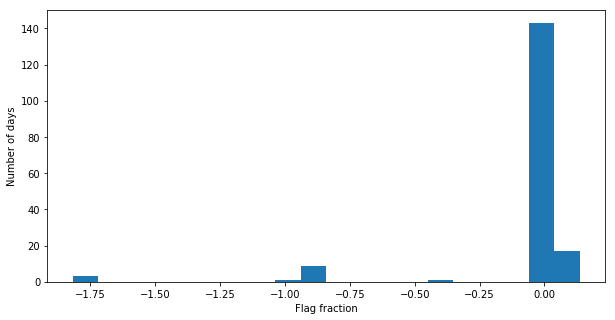

In [61]:
#Histogram of the number of days above a certain flag ratio
plt.figure(figsize=(10,5))
plt.hist(dayAvg,bins=20)
plt.xlabel('Flag fraction')
plt.ylabel('Number of days')
plt.show()

In [62]:
for i in range(len(heraTimeYDT)):
    heraTimeLocal[i]=[0]*len(heraTimeYDT[i])
    for j in range(len(heraTimeYDT[i])):
        heraTimeLocal[i][j]=heraTimeYDT[i][j].time()

In addition to the joyplot above, we can view the channel-averaged flag ratios when lined up according to LST, which may reveal any astronomical effects on the flagging.

Text(0.5,0,'LST')

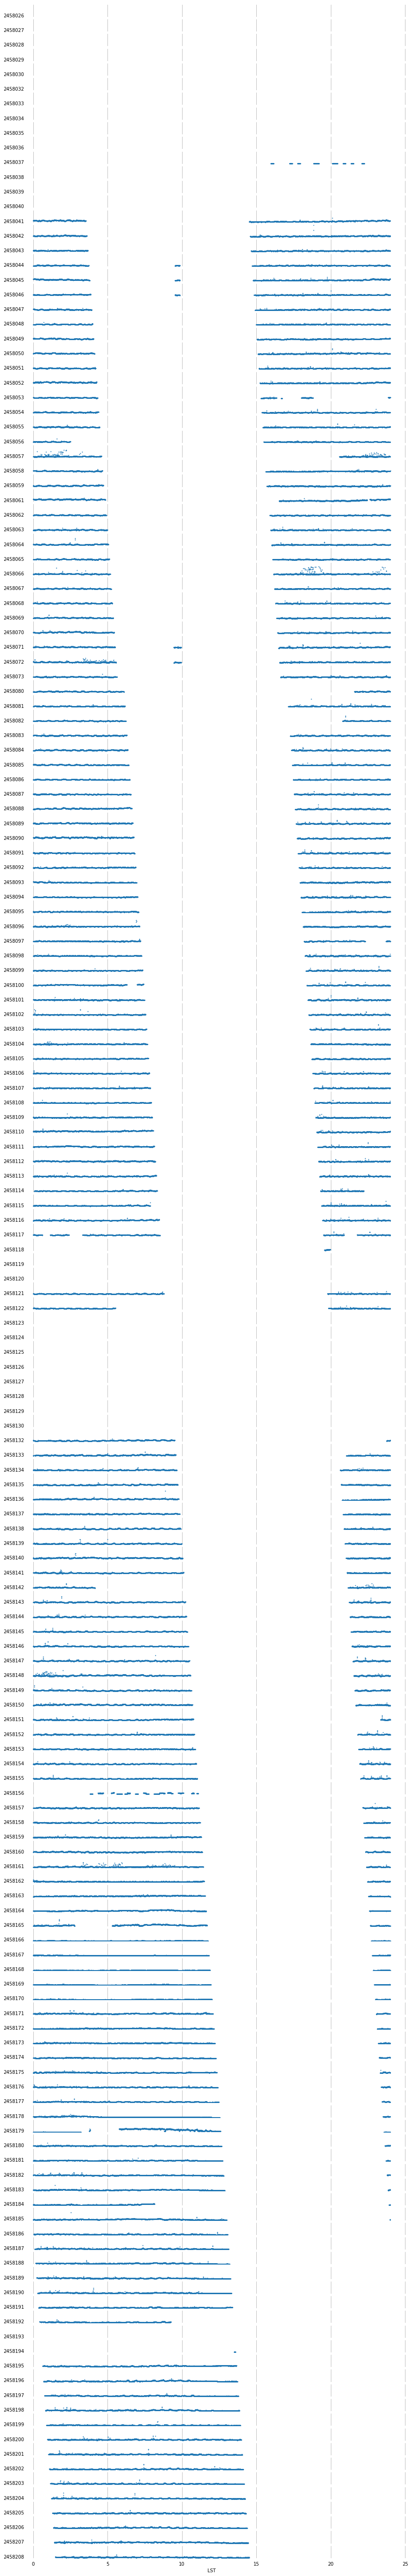

In [67]:
#plot using iterable vertical offset, horizontal offset based on LST
fig, axarr1=plt.subplots(numplts, 1, sharex='col', figsize=(15,100))
for i, plotfile in enumerate(plot_files):
#     print i
    openFile=np.load(plotfile)
    axarr1[i].plot(heraTimeLST[i], openFile['chan_mean_xx'], marker='.',markersize=2., ls='')
    axarr1[i].yaxis.set_visible(False)
    axarr1[i].set_ylim(0,.1)
    axarr1[i].tick_params(axis='x', bottom=False)
    axarr1[i].set_frame_on(False)
    axarr1[i].text(-2,0, notes[i][0])
    axarr1[i].grid()
    
plt.xlabel('LST')

We can also line up according to local time using JD, and look for any terrestrial effects that align with time.

Text(0.5,0,'Relative JD')

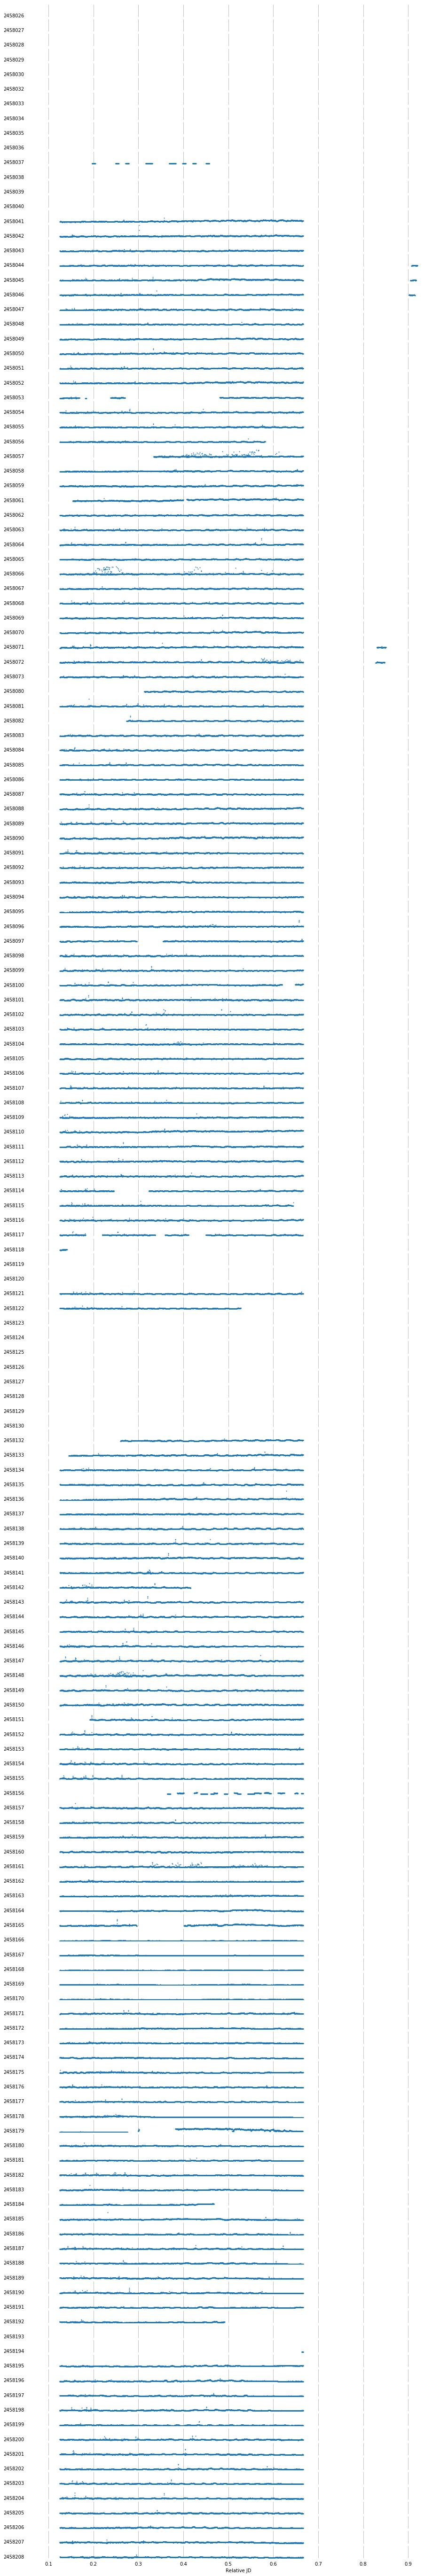

In [66]:
#plot using iterable vertical offset, horizontal offset based on local time
fig, axarr2=plt.subplots(numplts, 1, sharex='col', figsize=(15,100))
for i, plotfile in enumerate(plot_files):
#     print i
    openFile=np.load(plotfile)
    axarr2[i].plot(openFile['flag_times_xx']-int(notes[i][0]), openFile['chan_mean_xx'], marker='.',markersize=2, ls='')
    axarr2[i].yaxis.set_visible(False)
    axarr2[i].set_ylim(0,.1)
    axarr2[i].tick_params(axis='x', bottom=False)
    axarr2[i].set_frame_on(False)
    axarr2[i].text(0,0, notes[i][0])
    axarr2[i].grid()

plt.xlabel('Relative JD')


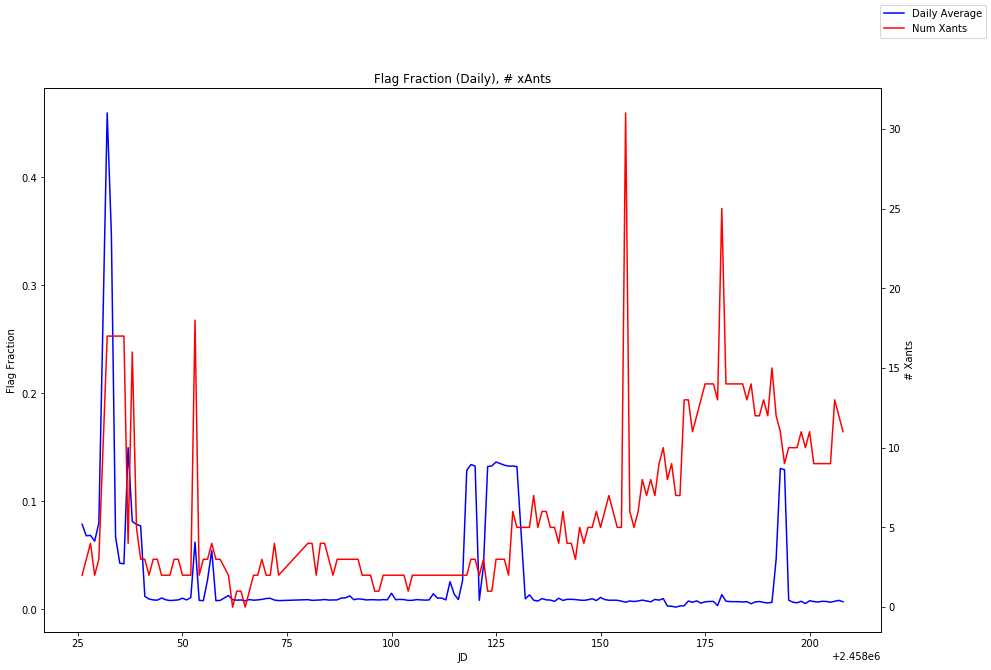

In [144]:
#daily average/xants
fig, ax1=plt.subplots(figsize=(15,10))
plt.title('Flag Fraction (Daily), # xAnts')
ax1.plot(jdArray,dayAvg, label='Daily Average', color='b')
# ax1.set_ylim(0,.3)
ax1.set_xlabel('JD')
ax1.set_ylabel('Flag Fraction')
ax2=ax1.twinx()
ax2.plot(jdArray,nxantArrxx, label='Num Xants', color='r')
ax2.set_ylabel('# Xants')
fig.legend()
plt.show()

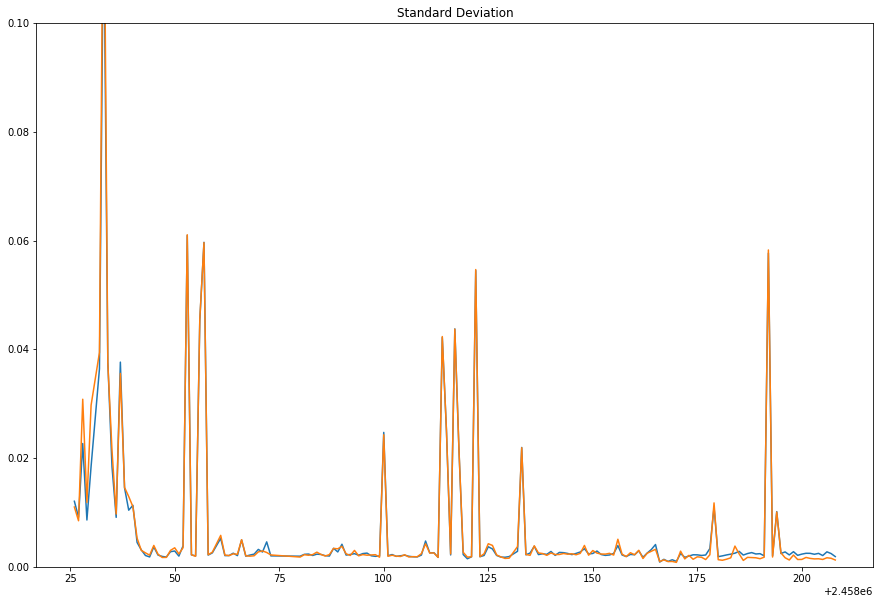

In [145]:
season_std_xx=[np.std(seasonFlag_xx[i])for i in range(len(seasonFlag_xx))]
season_std_yy=[np.std(seasonFlag_yy[i])for i in range(len(seasonFlag_yy))]
plt.figure(figsize=(15,10))
plt.title('Standard Deviation')
plt.plot(jdArray,season_std_xx, label='XX Polarization')
plt.plot(jdArray,season_std_yy, label='yy Polarization')
plt.ylim(0,.1)

plt.show()

In [ ]:
'''
To Do:
[ ]Fix early season flag fractions, check baseline sums for errors
[*]Plot of daily average/xants
[ ]Plot of standard deviation per JD

'''